In [36]:
import os
import copy
import torch
import json
import time
import math
import csv
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import seaborn as sns
import numpy as np
import random
from scipy.stats import wilcoxon
from scipy.stats import friedmanchisquare

import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from tqdm import tqdm
#from mlxtend.plotting import plot_decision_regions
from gpolnel.utils.tree import Tree
from gpolnel.problems.inductive_programming import SML
#from gpolnel.utils.utils import train_test_split
from gpolnel.utils.ffunctions import Ffunctions
from gpolnel.utils.tree import Tree
from gpolnel.utils.inductive_programming import function_map, _get_tree_depth
from gpolnel.algorithms.genetic_algorithm import GeneticAlgorithm, GSGP
from gpolnel.operators.initializers import grow, prm_grow, ERC, Terminal
from gpolnel.problems.problem import Problem
from gpolnel.operators.selectors import prm_tournament
#from gpolnel.operators.variators import prm_efficient_gs_mtn
from gpolnel.problems.inductive_programming import SMLGS, SML
from gpolnel.operators.variators import prm_gs_xo, prm_gs_mtn, prm_efficient_gs_xo, prm_efficient_gs_mtn
import codecs
import neat

#from gpolnel.operators.variators import prm_efficient_gs_mtn
#from gpolnel.operators.selectors import prm_tournament

In [2]:
data = pd.read_csv("data_project_nel.csv")
y_fat = pd.read_csv("y_fat.csv")
y_lactose = pd.read_csv("y_lactose.csv")
y_protein = pd.read_csv("y_protein.csv")

In [3]:
data.head()

,lactation,delivery_age_years,dim,dry_days,forage_kg_day,rumination_min_day,milk_kg_day,milk_kg_min_robot,milkings_day,errors_by_100_milkings,high_cdt_by_100_milkings,watery_by_100_milkings,refusals_by_milking,colostrum_separated_kg
0,7,7.750000,414,56.0,4.310918,434.814010,34.082367,3.695699,2.478261,2.046784,0.0,0.000000,0.077973,0.0
1,8,9.083333,357,78.0,4.167087,589.500000,36.170868,4.024165,2.176471,0.900901,0.0,0.000000,0.014157,0.0
2,6,7.666667,315,69.0,4.903333,542.577778,43.371746,2.715252,2.387302,1.063830,0.0,0.132979,0.045213,12.8
3,7,8.666667,362,69.0,4.294724,628.371901,41.683149,2.733291,2.193370,1.763224,0.0,0.000000,0.061713,16.2
4,5,6.500000,427,58.0,4.798618,479.334112,37.916393,1.888608,3.142857,0.745156,0.0,0.000000,0.444858,20.2


In [4]:
data.shape

(324, 14)

In [5]:
y_fat.head()

,fat_percent
0,3.787156
1,3.645519
2,3.458251
3,3.407140
4,4.902554


In [6]:
y_fat.shape

(324, 1)

In [7]:
y_lactose.head()

,lactose_percent
0,4.953503
1,4.983128
2,4.889104
3,4.868969
4,4.845402


In [8]:
y_lactose.shape

(324, 1)

In [9]:
y_protein.head()

,protein_percent
0,3.511685
1,3.470806
2,3.370124
3,3.221164
4,3.395152


In [10]:
y_protein.shape

(324, 1)

In [11]:
data = pd.concat([data, y_lactose, y_fat, y_protein], axis=1)

In [12]:
data.head()

,lactation,delivery_age_years,dim,dry_days,forage_kg_day,rumination_min_day,milk_kg_day,milk_kg_min_robot,milkings_day,errors_by_100_milkings,high_cdt_by_100_milkings,watery_by_100_milkings,refusals_by_milking,colostrum_separated_kg,lactose_percent,fat_percent,protein_percent
0,7,7.750000,414,56.0,4.310918,434.814010,34.082367,3.695699,2.478261,2.046784,0.0,0.000000,0.077973,0.0,4.953503,3.787156,3.511685
1,8,9.083333,357,78.0,4.167087,589.500000,36.170868,4.024165,2.176471,0.900901,0.0,0.000000,0.014157,0.0,4.983128,3.645519,3.470806
2,6,7.666667,315,69.0,4.903333,542.577778,43.371746,2.715252,2.387302,1.063830,0.0,0.132979,0.045213,12.8,4.889104,3.458251,3.370124
3,7,8.666667,362,69.0,4.294724,628.371901,41.683149,2.733291,2.193370,1.763224,0.0,0.000000,0.061713,16.2,4.868969,3.407140,3.221164
4,5,6.500000,427,58.0,4.798618,479.334112,37.916393,1.888608,3.142857,0.745156,0.0,0.000000,0.444858,20.2,4.845402,4.902554,3.395152


In [13]:
data.isnull().sum()

lactation                     0
delivery_age_years            0
dim                           0
dry_days                    147
forage_kg_day                 0
rumination_min_day            0
milk_kg_day                   0
milk_kg_min_robot             0
milkings_day                  0
errors_by_100_milkings        0
high_cdt_by_100_milkings      0
watery_by_100_milkings        0
refusals_by_milking           0
colostrum_separated_kg        0
lactose_percent               0
fat_percent                   0
protein_percent               0
dtype: int64

In [14]:
data.drop('dry_days', axis=1, inplace=True)

C:\Users\jaime\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\jaime\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\jaime\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\jaime\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

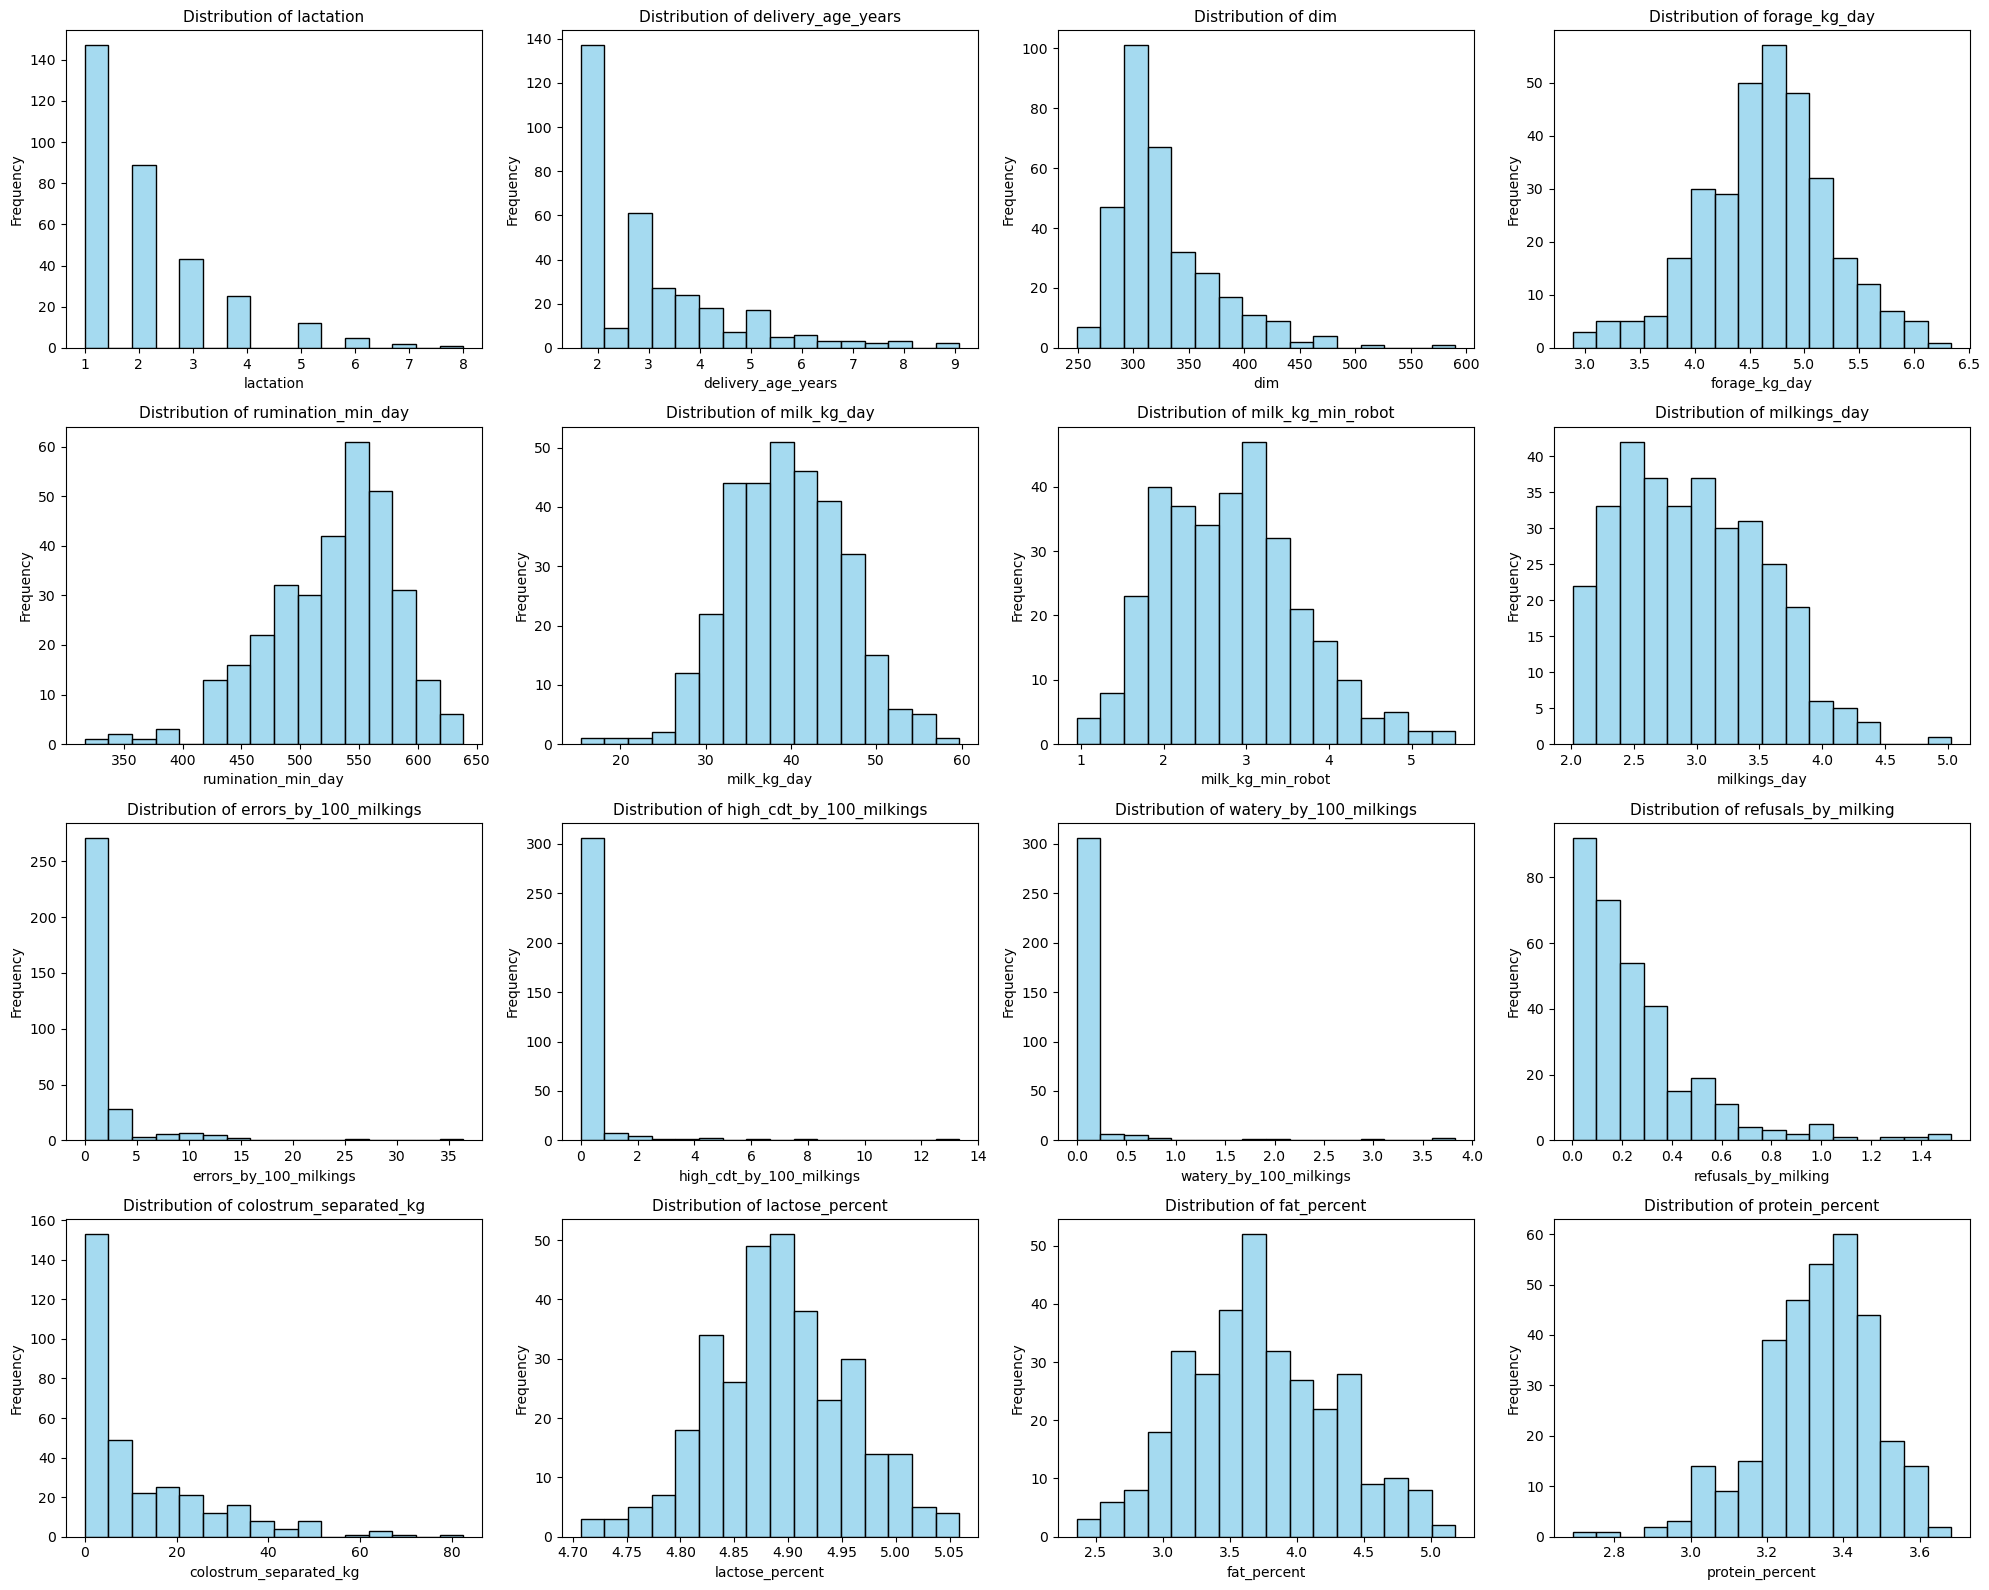

In [15]:
num_columns = len(data.columns)

# Number of rows and columns for subplots
n_rows = 4
n_cols = 4

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 16))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot each column
for i, column in enumerate(data.columns):
    sns.histplot(data[column], bins=16, kde=False, color='skyblue', ax=axes[i], edgecolor='black')
    axes[i].set_title(f'Distribution of {column}', fontsize=11)
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Frequency')

# Remove any unused subplots
for j in range(i+1, n_rows*n_cols):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [16]:
#lactation is categorical so we did one hot encoding here
data = pd.get_dummies(data, columns=['lactation'])
data.iloc[:, -7:] = data.iloc[:, -7:].astype(int)

In [17]:
data.head()

,delivery_age_years,dim,forage_kg_day,rumination_min_day,milk_kg_day,milk_kg_min_robot,milkings_day,errors_by_100_milkings,high_cdt_by_100_milkings,watery_by_100_milkings,...,fat_percent,protein_percent,lactation_1,lactation_2,lactation_3,lactation_4,lactation_5,lactation_6,lactation_7,lactation_8
0,7.750000,414,4.310918,434.814010,34.082367,3.695699,2.478261,2.046784,0.0,0.000000,...,3.787156,3.511685,False,0,0,0,0,0,1,0
1,9.083333,357,4.167087,589.500000,36.170868,4.024165,2.176471,0.900901,0.0,0.000000,...,3.645519,3.470806,False,0,0,0,0,0,0,1
2,7.666667,315,4.903333,542.577778,43.371746,2.715252,2.387302,1.063830,0.0,0.132979,...,3.458251,3.370124,False,0,0,0,0,1,0,0
3,8.666667,362,4.294724,628.371901,41.683149,2.733291,2.193370,1.763224,0.0,0.000000,...,3.407140,3.221164,False,0,0,0,0,0,1,0
4,6.500000,427,4.798618,479.334112,37.916393,1.888608,3.142857,0.745156,0.0,0.000000,...,4.902554,3.395152,False,0,0,0,1,0,0,0


In [18]:
spearman_corr_matrix = data.corr(method='spearman')

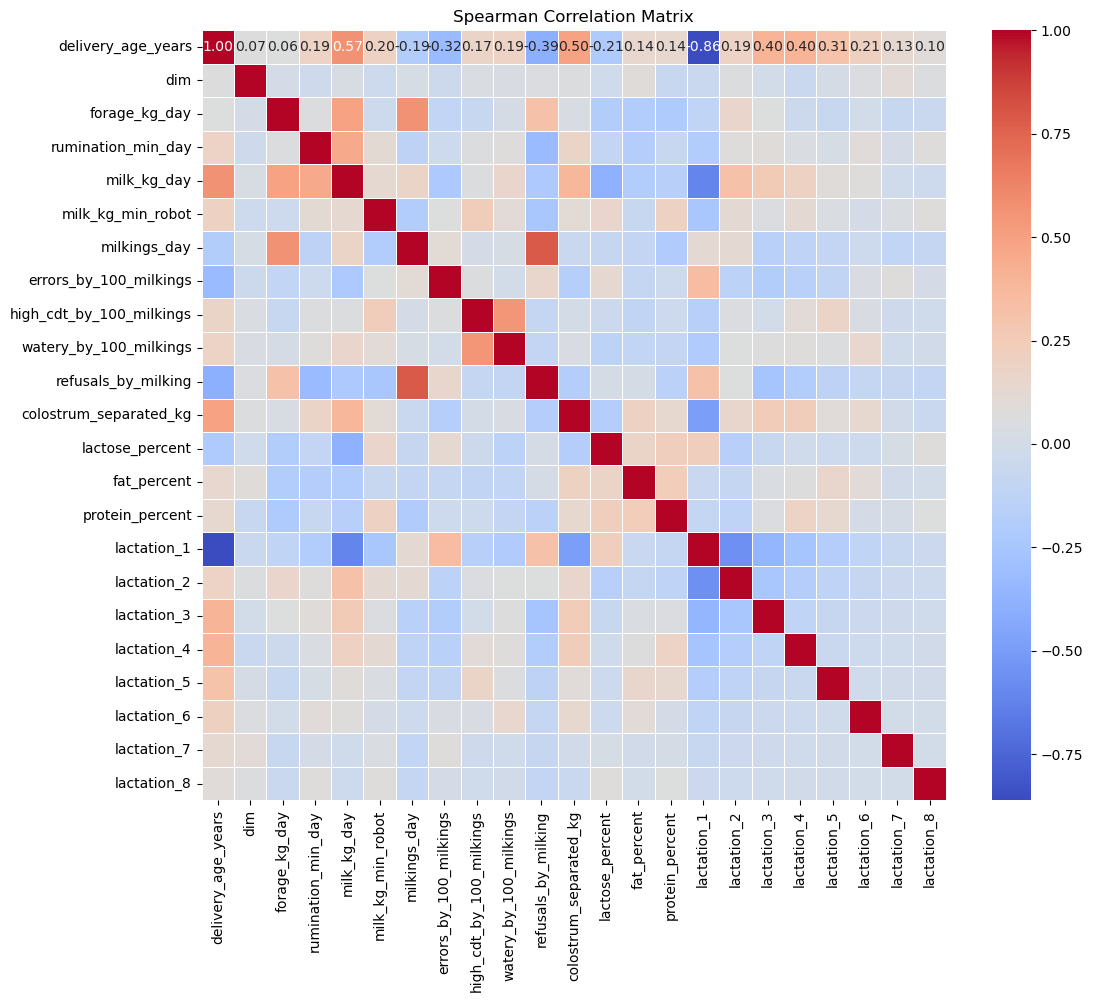

In [19]:
plt.figure(figsize=(12, 10))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(spearman_corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=.5)

# Add title
plt.title('Spearman Correlation Matrix')
plt.show()

C:\Users\jaime\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\jaime\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\jaime\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\jaime\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

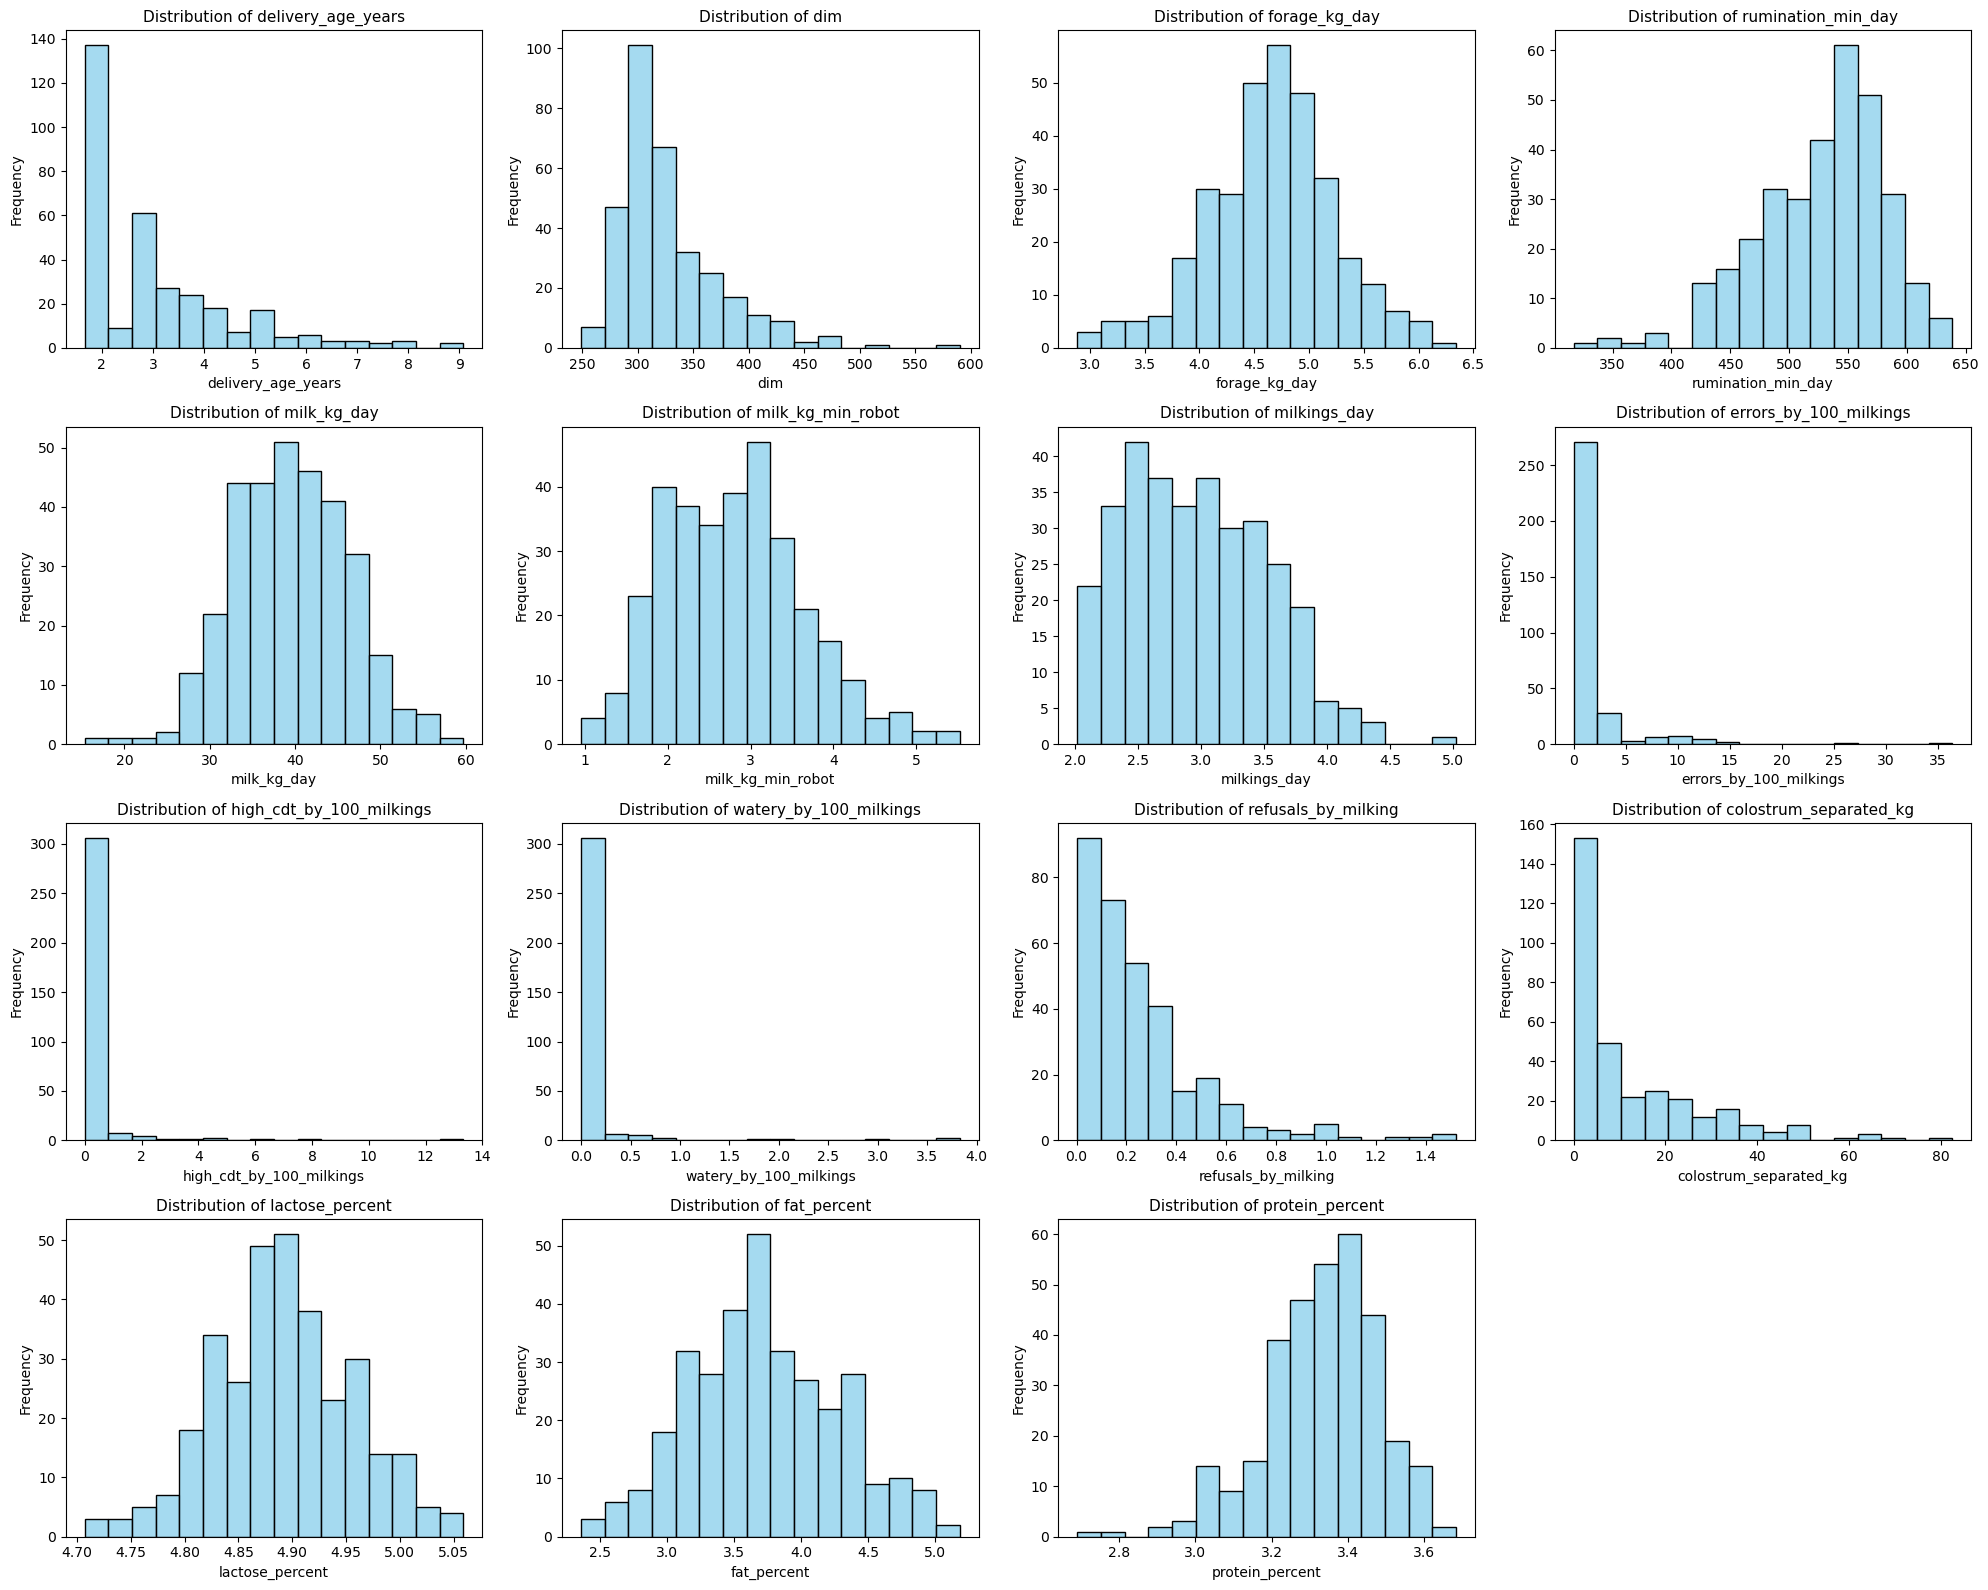

In [20]:
columns_to_plot = [col for col in data.columns if not col.startswith('lactation_')]

num_columns = len(columns_to_plot)

n_rows = 4
n_cols = 4

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 16))

axes = axes.flatten()

for i, column in enumerate(columns_to_plot):
    sns.histplot(data[column], bins=16, kde=False, color='skyblue', ax=axes[i], edgecolor='black')
    axes[i].set_title(f'Distribution of {column}', fontsize=11)
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Frequency')

for j in range(i+1, n_rows*n_cols):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [21]:
X = data.drop(columns=["fat_percent", "lactose_percent", "protein_percent"])
y_fat = data["fat_percent"]
y_lactose = data["lactose_percent"]
y_protein = data["protein_percent"]

In [22]:
k = 5  
kf = KFold(n_splits=k, shuffle=True, random_state=42)

scaler = StandardScaler()

X_train_kf, X_val_kf = [], []
y_fat_train_kf, y_fat_val_kf = [], []
y_lactose_train_kf, y_lactose_val_kf = [], []
y_protein_train_kf, y_protein_val_kf = [], []

for train_index, val_index in kf.split(X):
    X_train_fold, X_val_fold = X.iloc[train_index], X.iloc[val_index]
    y_fat_train_fold, y_fat_val_fold = y_fat.iloc[train_index], y_fat.iloc[val_index]
    y_lactose_train_fold, y_lactose_val_fold = y_lactose.iloc[train_index], y_lactose.iloc[val_index]
    y_protein_train_fold, y_protein_val_fold = y_protein.iloc[train_index], y_protein.iloc[val_index]

    # Scaler
    X_train_fold_scaled = scaler.fit_transform(X_train_fold)
    X_val_fold_scaled = scaler.transform(X_val_fold)

    # Convert to PyTorch tensors
    X_train_fold_tensor = torch.tensor(X_train_fold_scaled, dtype=torch.float32)
    X_val_fold_tensor = torch.tensor(X_val_fold_scaled, dtype=torch.float32)
    y_fat_train_fold_tensor = torch.tensor(y_fat_train_fold.to_numpy(), dtype=torch.float32).view(-1, 1)
    y_fat_val_fold_tensor = torch.tensor(y_fat_val_fold.to_numpy(), dtype=torch.float32).view(-1, 1)
    y_lactose_train_fold_tensor = torch.tensor(y_lactose_train_fold.to_numpy(), dtype=torch.float32).view(-1, 1)
    y_lactose_val_fold_tensor = torch.tensor(y_lactose_val_fold.to_numpy(), dtype=torch.float32).view(-1, 1)
    y_protein_train_fold_tensor = torch.tensor(y_protein_train_fold.to_numpy(), dtype=torch.float32).view(-1, 1)
    y_protein_val_fold_tensor = torch.tensor(y_protein_val_fold.to_numpy(), dtype=torch.float32).view(-1, 1)

    # Append to lists
    X_train_kf.append(X_train_fold_tensor)
    X_val_kf.append(X_val_fold_tensor)
    y_fat_train_kf.append(y_fat_train_fold_tensor)
    y_fat_val_kf.append(y_fat_val_fold_tensor)
    y_lactose_train_kf.append(y_lactose_train_fold_tensor)
    y_lactose_val_kf.append(y_lactose_val_fold_tensor)
    y_protein_train_kf.append(y_protein_train_fold_tensor)
    y_protein_val_kf.append(y_protein_val_fold_tensor)

# NEURAL NETWORK

In [23]:
def dataloaders(X_train_kf, X_val_kf, y_train_kf, y_val_kf, batch_sizes):
    train_data = []
    val_data = []

    for i in range(len(X_train_kf)):
        train_ds = TensorDataset(X_train_kf[i], y_train_kf[i])
        val_ds = TensorDataset(X_val_kf[i], y_val_kf[i])

        batch_size_GD = batch_sizes['GD']
        batch_size_SGD = batch_sizes['SGD']
        batch_size_MiniSGD = batch_sizes['MiniSGD']
        batch_size_ASGD = batch_sizes['ASGD']
        batch_size_RMSprop = batch_sizes['RMSprop']

        train_dl_GD = DataLoader(train_ds, batch_size_GD, shuffle=True)
        val_dl_GD = DataLoader(val_ds, batch_size_GD, shuffle=True)
        train_dl_SGD = DataLoader(train_ds, batch_size_SGD, shuffle=True)
        val_dl_SGD = DataLoader(val_ds, batch_size_SGD, shuffle=True)
        train_dl_MiniSGD = DataLoader(train_ds, batch_size_MiniSGD, shuffle=True)
        val_dl_MiniSGD = DataLoader(val_ds, batch_size_MiniSGD, shuffle=True)
        train_dl_ASGD = DataLoader(train_ds, batch_size_ASGD, shuffle=True)
        val_dl_ASGD = DataLoader(val_ds, batch_size_ASGD, shuffle=True)
        train_dl_RMSprop = DataLoader(train_ds, batch_size_RMSprop, shuffle=True)
        val_dl_RMSprop = DataLoader(val_ds, batch_size_RMSprop, shuffle=True)
        
        train_data.append({
            'GD': train_dl_GD,
            'SGD': train_dl_SGD,
            'MiniSGD': train_dl_MiniSGD,
            'ASGD': train_dl_ASGD,
            'RMSprop': train_dl_RMSprop
        })

        val_data.append({
            'GD': val_dl_GD,
            'SGD': val_dl_SGD,
            'MiniSGD': val_dl_MiniSGD,
            'ASGD': val_dl_ASGD,
            'RMSprop': val_dl_RMSprop
        })

    return train_data, val_data

# Define batch sizes for each optimizer
batch_sizes = {
    'GD': X_train_kf[0].shape[0],
    'SGD': 1,
    'MiniSGD': 32,
    'ASGD': 64,
    'RMSprop': 128
}

# Get dataloaders for each percentage
fat_train_data, fat_val_data = dataloaders(X_train_kf, X_val_kf, y_fat_train_kf, y_fat_val_kf, batch_sizes)
lactose_train_data, lactose_val_data = dataloaders(X_train_kf, X_val_kf, y_lactose_train_kf, y_lactose_val_kf, batch_sizes)
protein_train_data, protein_val_data = dataloaders(X_train_kf, X_val_kf, y_protein_train_kf, y_protein_val_kf, batch_sizes)

In [24]:
class Net(nn.Module):
    def __init__(self, input_dim):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 16)
        self.fc4 = nn.Linear(16, 1)
        self.activation = nn.ReLU()
        self.apply(self._init_weights)
    
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            nn.init.xavier_uniform_(module.weight)
            nn.init.zeros_(module.bias)
    
    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.activation(self.fc3(x))
        x = torch.sigmoid(self.fc4(x))
        return x

    def train_model(self, num_epochs, loss_fn, optimizer, train_dl, val_dl, train_size, val_size, batch_size):
        self.apply(self._init_weights)
        loss_hist_train = [0] * num_epochs
        rmse_hist_train = [0] * num_epochs
        loss_hist_valid = [0] * num_epochs
        rmse_hist_valid = [0] * num_epochs

        for epoch in tqdm(range(num_epochs)):
            epoch_train_loss = 0
            train_predictions = []
            train_targets = []
            self.train()
            for x_batch, y_batch in train_dl:
                pred = self(x_batch)
                loss = loss_fn(pred, y_batch)
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()
                epoch_train_loss += loss.item()
                train_predictions.append(pred.detach().cpu().numpy())
                train_targets.append(y_batch.detach().cpu().numpy())

            train_predictions = np.concatenate(train_predictions)
            train_targets = np.concatenate(train_targets)
            loss_hist_train[epoch] = epoch_train_loss / (train_size / batch_size)
            rmse_hist_train[epoch] = compute_rmse(train_predictions, train_targets)

            self.eval()
            with torch.no_grad():
                val_predictions = []
                val_targets = []
                for x_batch, y_batch in val_dl:
                    pred = self(x_batch)
                    val_predictions.append(pred.detach().cpu().numpy())
                    val_targets.append(y_batch.detach().cpu().numpy())

                val_predictions = np.concatenate(val_predictions)
                val_targets = np.concatenate(val_targets)
                valid_loss = loss_fn(torch.tensor(val_predictions), torch.tensor(val_targets)).item()
                loss_hist_valid[epoch] = valid_loss
                rmse_hist_valid[epoch] = compute_rmse(val_predictions, val_targets)

        return loss_hist_train, loss_hist_valid, rmse_hist_train, rmse_hist_valid


# Function to compute RMSE
def compute_rmse(predictions, targets):
    return np.sqrt(np.mean((predictions - targets) ** 2))

def train_and_evaluate_kfold(model, optimizer, num_epochs, loss_fn, X_kf, y_kf):
    history = {}

    for fold_idx, ((X_train_fold, X_val_fold), (y_train_fold, y_val_fold)) in enumerate(zip(X_kf, y_kf)):
        print(f"Training models for fold {fold_idx + 1}...")
        train_ds = TensorDataset(X_train_fold, y_train_fold)
        val_ds = TensorDataset(X_val_fold, y_val_fold)

        train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
        val_dl = DataLoader(val_ds, batch_size=batch_size, shuffle=False)

        model_instance = model(input_dim=X_train_fold.shape[1])
        optimizer_instance = optimizer(model_instance.parameters(), lr=learning_rate)

        history_fold = model_instance.train_model(
            num_epochs=num_epochs,
            loss_fn=loss_fn,
            optimizer=optimizer_instance,
            train_dl=train_dl,
            val_dl=val_dl,
            train_size=len(train_dl.dataset),
            val_size=len(val_dl.dataset),
            batch_size=batch_size
        )

        history[f'Fold_{fold_idx + 1}'] = history_fold

    return history

# Instantiate the neural networks for each target variable
input_dim = X_train_fold.shape[1]
nn_names = ['GD', 'SGD', 'MiniSGD', 'ASGD', 'RMSprop']
nn_torch = {k: Net(input_dim) for k in nn_names}

# Define loss function
loss_fn = nn.MSELoss()

# Define learning rates
learning_rates = {
    'GD': 0.05,
    'SGD': 0.05,
    'MiniSGD': 0.05,
    'ASGD': 0.05,
    'RMSprop': 0.05
}

# Define optimizers
optimizers = {
    'GD': torch.optim.SGD,
    'SGD': torch.optim.SGD,
    'MiniSGD': torch.optim.SGD,
    'ASGD': torch.optim.ASGD,
    'RMSprop': torch.optim.RMSprop
}
num_epochs = 15

In [25]:
def prepare_kfold_data(X, y, k):
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    scaler = StandardScaler()

    X_kf, y_kf = [], []
    for train_index, val_index in kf.split(X):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

        X_train_scaled = scaler.fit_transform(X_train)
        X_val_scaled = scaler.transform(X_val)

        X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
        X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32)
        y_train_tensor = torch.tensor(y_train.to_numpy(), dtype=torch.float32).view(-1, 1)
        y_val_tensor = torch.tensor(y_val.to_numpy(), dtype=torch.float32).view(-1, 1)

        X_kf.append((X_train_tensor, X_val_tensor))
        y_kf.append((y_train_tensor, y_val_tensor))

    return X_kf, y_kf

def train_and_evaluate_kfold(models, optimizers, num_epochs, loss_fn, X_kf, y_kf, batch_sizes, learning_rates):
    history = {}

    for nn_name, model in models.items():
        optimizer = optimizers[nn_name]
        history_nn = {}
        for fold_idx, ((X_train_fold, X_val_fold), (y_train_fold, y_val_fold)) in enumerate(zip(X_kf, y_kf)):
            print(f"Training {nn_name} for fold {fold_idx + 1}...")
            train_ds = TensorDataset(X_train_fold, y_train_fold)
            val_ds = TensorDataset(X_val_fold, y_val_fold)

            # Retrieve the batch size for the current optimizer
            batch_size = batch_sizes[nn_name]

            train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
            val_dl = DataLoader(val_ds, batch_size=batch_size, shuffle=False)

            optimizer_instance = optimizer(model.parameters(), lr=learning_rates[nn_name])

            history_fold = model.train_model(
                num_epochs=num_epochs,
                loss_fn=loss_fn,
                optimizer=optimizer_instance,
                train_dl=train_dl,
                val_dl=val_dl,
                train_size=len(train_dl.dataset),
                val_size=len(val_dl.dataset),
                batch_size=batch_size  # Use the retrieved batch size
            )

            print(f"Fold {fold_idx + 1} history for {nn_name}: {history_fold}")  # Debug print

            history_nn[f'Fold_{fold_idx + 1}'] = history_fold

        history[nn_name] = history_nn

    return history

def compute_average_history(history):
    avg_history = {}

    for nn_name, folds_history in history.items():
        # Assuming each fold contains a list of tuples (train_loss, val_loss, additional_metrics...)
        first_fold_metrics = folds_history[list(folds_history.keys())[0]]
        num_metrics = len(first_fold_metrics)  # Determine the number of metrics
        
        # Initialize avg_history_nn with the appropriate keys
        avg_history_nn = {f'metric_{i}': [] for i in range(num_metrics)}

        for fold_name, metrics in folds_history.items():
            #print(f"Fold {fold_name} metrics for {nn_name}: {metrics}")  # Debug print

            for i, values in enumerate(metrics):
                key = f'metric_{i}'
                for epoch in range(len(values)):
                    if len(avg_history_nn[key]) <= epoch:
                        avg_history_nn[key].append(0)
                    avg_history_nn[key][epoch] += values[epoch]

        num_folds = len(folds_history)
        for key in avg_history_nn:
            avg_history_nn[key] = [value / num_folds for value in avg_history_nn[key]]
        
        avg_history[nn_name] = avg_history_nn

    return avg_history

# Assuming batch_sizes and learning_rates are dictionaries mapping model names to their corresponding values
X_fat_kf, y_fat_kf = prepare_kfold_data(X, y_fat, k)
X_lactose_kf, y_lactose_kf = prepare_kfold_data(X, y_lactose, k)
X_protein_kf, y_protein_kf = prepare_kfold_data(X, y_protein, k)

# Call the function with the appropriate parameters
history_kfold_fat = train_and_evaluate_kfold(nn_torch, optimizers, num_epochs, loss_fn, X_fat_kf, y_fat_kf, batch_sizes, learning_rates)
history_kfold_lactose = train_and_evaluate_kfold(nn_torch, optimizers, num_epochs, loss_fn, X_lactose_kf, y_lactose_kf, batch_sizes, learning_rates)
history_kfold_protein = train_and_evaluate_kfold(nn_torch, optimizers, num_epochs, loss_fn, X_protein_kf, y_protein_kf, batch_sizes, learning_rates)

# Compute average histories
avg_history_fat = compute_average_history(history_kfold_fat)
avg_history_lactose = compute_average_history(history_kfold_lactose)
avg_history_protein = compute_average_history(history_kfold_protein)



Training GD for fold 1...


100%|██████████| 15/15 [00:00<00:00, 38.75it/s]


Fold 1 history for GD: ([10.606595993041992, 9.65835952758789, 8.96917724609375, 8.53418254852295, 8.276793479919434, 8.125101089477539, 8.032027244567871, 7.9718918800354, 7.930798053741455, 7.9015889167785645, 7.880044460296631, 7.863625526428223, 7.850830554962158, 7.840658187866211, 7.832406044006348], [9.397769927978516, 8.717401504516602, 8.300545692443848, 8.060359001159668, 7.921463489532471, 7.837610721588135, 7.78410005569458, 7.7480010986328125, 7.722635746002197, 7.704103469848633, 7.690110683441162, 7.679269790649414, 7.67069673538208, 7.663780212402344, 7.658111572265625], [3.2567768, 3.1077902, 2.9948585, 2.9213321, 2.8769417, 2.8504565, 2.834083, 2.823454, 2.8161674, 2.8109765, 2.8071415, 2.8042157, 2.8019335, 2.8001175, 2.7986436], [3.0655782, 2.9525247, 2.8810668, 2.8390772, 2.8145094, 2.7995734, 2.7899997, 2.7835233, 2.778963, 2.7756267, 2.7731047, 2.7711494, 2.7696023, 2.7683535, 2.7673292])
Training GD for fold 2...


100%|██████████| 15/15 [00:00<00:00, 62.48it/s]


Fold 2 history for GD: ([9.882857322692871, 9.384943008422852, 8.943228721618652, 8.588862419128418, 8.325547218322754, 8.14063549041748, 8.012600898742676, 7.923484802246094, 7.86043643951416, 7.814676761627197, 7.780766487121582, 7.7550272941589355, 7.7350687980651855, 7.719295501708984, 7.706607341766357], [9.95579719543457, 9.500948905944824, 9.141032218933105, 8.877543449401855, 8.69583511352539, 8.572766304016113, 8.488983154296875, 8.43075942993164, 8.3892240524292, 8.3588285446167, 8.336008071899414, 8.318487167358398, 8.304740905761719, 8.293763160705566, 8.284855842590332], [3.1437013, 3.0634854, 2.990523, 2.9306762, 2.8854022, 2.8531797, 2.830654, 2.8148685, 2.803647, 2.7954743, 2.7894027, 2.7847848, 2.781199, 2.778362, 2.7760777], [3.1552808, 3.082361, 3.023414, 2.9795208, 2.9488704, 2.9279287, 2.913586, 2.9035769, 2.8964155, 2.8911638, 2.8872144, 2.8841789, 2.881795, 2.8798895, 2.8783426])
Training GD for fold 3...


100%|██████████| 15/15 [00:00<00:00, 67.58it/s]


Fold 3 history for GD: ([11.080519676208496, 10.612622261047363, 10.251587867736816, 9.943053245544434, 9.654515266418457, 9.373331069946289, 9.10505485534668, 8.859009742736816, 8.64224624633789, 8.459650039672852, 8.31137466430664, 8.195719718933105, 8.106932640075684, 8.03880786895752, 7.986186504364014], [10.658807754516602, 10.303771018981934, 9.995596885681152, 9.705538749694824, 9.425565719604492, 9.160829544067383, 8.918767929077148, 8.705277442932129, 8.525073051452637, 8.37811279296875, 8.262242317199707, 8.17221450805664, 8.10234260559082, 8.047924041748047, 8.004997253417969], [3.3287416, 3.2577019, 3.2018101, 3.1532607, 3.107172, 3.0615897, 3.0174582, 2.976409, 2.9397697, 2.9085476, 2.882945, 2.8628168, 2.8472674, 2.8352792, 2.8259842], [3.264783, 3.2099488, 3.1615813, 3.1153712, 3.0701084, 3.0266862, 2.9864304, 2.9504707, 2.9197729, 2.8944972, 2.8744116, 2.8587084, 2.8464615, 2.8368864, 2.8293107])
Training GD for fold 4...


100%|██████████| 15/15 [00:00<00:00, 60.07it/s]


Fold 4 history for GD: ([10.153377532958984, 9.586203575134277, 9.035192489624023, 8.590339660644531, 8.295453071594238, 8.112931251525879, 8.000086784362793, 7.928461074829102, 7.880908012390137, 7.847883224487305, 7.823868274688721, 7.805810928344727, 7.791889667510986, 7.780908584594727, 7.772097587585449], [9.698939323425293, 9.137100219726562, 8.694477081298828, 8.405908584594727, 8.231600761413574, 8.125703811645508, 8.059194564819336, 8.015328407287598, 7.9849748611450195, 7.9630584716796875, 7.946656227111816, 7.934075355529785, 7.924153804779053, 7.916196823120117, 7.909698009490967], [3.1864364, 3.0961595, 3.0058596, 2.9309282, 2.8801827, 2.8483207, 2.8284426, 2.8157523, 2.8072953, 2.8014073, 2.797118, 2.793888, 2.791396, 2.789428, 2.7878482], [3.114312, 3.0227635, 2.9486399, 2.8992946, 2.8690765, 2.8505619, 2.838872, 2.8311353, 2.8257697, 2.8218892, 2.8189812, 2.816749, 2.8149872, 2.8135738, 2.8124185])
Training GD for fold 5...


100%|██████████| 15/15 [00:00<00:00, 56.38it/s]


Fold 5 history for GD: ([19.035148273981534, 21.981815708600557, 17.7642278946363, 15.226553863745469, 17.874604856050933, 14.105500784287086, 15.69953636939709, 15.755757744495686, 15.83390811590048, 12.70231957252209, 14.294150667924148, 13.962950908220732, 15.058293966146616, 18.176206218279326, 12.247749614715577], [10.37047290802002, 9.477157592773438, 8.705695152282715, 8.240527153015137, 7.785870552062988, 7.6544389724731445, 7.507552146911621, 7.415192127227783, 7.350808143615723, 7.329351425170898, 7.31522798538208, 7.304379940032959, 7.290187358856201, 7.269037246704102, 7.264748573303223], [3.478889, 3.335602, 3.182038, 3.0545805, 2.9793072, 2.9018211, 2.87982, 2.8550324, 2.839026, 2.827037, 2.8232093, 2.8206766, 2.8187375, 2.8161204, 2.8123298], [3.220322, 3.0784993, 2.9505415, 2.870632, 2.790317, 2.7666657, 2.7399912, 2.723085, 2.7112374, 2.7072773, 2.7046678, 2.7026618, 2.7000349, 2.6961153, 2.69532])
Training SGD for fold 1...


100%|██████████| 15/15 [00:12<00:00,  1.21it/s]


Fold 1 history for SGD: ([7.818106396317942, 7.767558787780379, 7.767202745533358, 7.767070338072464, 7.767001808380068, 7.76696033367319, 7.766932680339887, 7.76691299055534, 7.766898351286369, 7.766886995105669, 7.766878070518317, 7.766870776198545, 7.766864743472066, 7.766859626217698, 7.766855386233238], [7.611188888549805, 7.610671520233154, 7.6105194091796875, 7.610450267791748, 7.610409736633301, 7.610385417938232, 7.6103668212890625, 7.610355377197266, 7.610344886779785, 7.610337734222412, 7.6103315353393555, 7.610327243804932, 7.610322952270508, 7.610318660736084, 7.610315799713135], [2.7960877, 2.787034, 2.7869701, 2.7869463, 2.7869341, 2.7869267, 2.7869217, 2.7869182, 2.7869155, 2.7869136, 2.786912, 2.7869105, 2.7869096, 2.7869086, 2.786908], [2.7588384, 2.7587447, 2.758717, 2.7587044, 2.7586973, 2.7586925, 2.7586894, 2.7586873, 2.7586854, 2.7586842, 2.758683, 2.758682, 2.7586813, 2.7586806, 2.75868])
Training SGD for fold 2...


100%|██████████| 15/15 [00:13<00:00,  1.12it/s]


Fold 2 history for SGD: ([7.6663625300160705, 7.615518842424665, 7.61519468014765, 7.615070508713888, 7.615005556220714, 7.614966004511564, 7.614939563983196, 7.614920777703804, 7.614906647490718, 7.614895823379281, 7.614887191061808, 7.61488013239901, 7.614874255242955, 7.6148693842317146, 7.614865190734274], [8.217015266418457, 8.216414451599121, 8.216225624084473, 8.216135025024414, 8.216081619262695, 8.216046333312988, 8.216023445129395, 8.216005325317383, 8.215991973876953, 8.215981483459473, 8.215972900390625, 8.21596622467041, 8.215959548950195, 8.215954780578613, 8.215950012207031], [2.7688196, 2.759623, 2.7595642, 2.7595417, 2.7595298, 2.759523, 2.759518, 2.7595146, 2.759512, 2.75951, 2.7595086, 2.7595074, 2.7595062, 2.7595053, 2.7595046], [2.8665338, 2.8664289, 2.866396, 2.86638, 2.866371, 2.8663647, 2.8663607, 2.8663576, 2.8663552, 2.8663533, 2.8663518, 2.8663504, 2.8663495, 2.8663485, 2.866348])
Training SGD for fold 3...


100%|██████████| 15/15 [00:09<00:00,  1.65it/s]


Fold 3 history for SGD: ([7.770562990291698, 7.728124289438991, 7.7277848628497035, 7.72765947999181, 7.727594728175277, 7.7275557370719765, 7.727529785807989, 7.7275112126324625, 7.727497443269119, 7.727486862178935, 7.72747845723362, 7.72747164665502, 7.727466015281824, 7.727461248291045, 7.72745726973854], [7.768270969390869, 7.767698764801025, 7.767528533935547, 7.767450332641602, 7.767404556274414, 7.76737642288208, 7.767355442047119, 7.767341136932373, 7.767329216003418, 7.76732063293457, 7.7673139572143555, 7.767307758331299, 7.767302513122559, 7.767298698425293, 7.767296314239502], [2.787573, 2.7799504, 2.7798893, 2.7798667, 2.7798553, 2.7798483, 2.7798433, 2.7798402, 2.7798376, 2.7798357, 2.7798343, 2.779833, 2.7798321, 2.7798312, 2.7798305], [2.7871618, 2.787059, 2.7870288, 2.7870145, 2.7870064, 2.7870011, 2.7869976, 2.786995, 2.7869928, 2.7869914, 2.7869902, 2.7869892, 2.7869883, 2.7869875, 2.7869868])
Training SGD for fold 4...


100%|██████████| 15/15 [00:08<00:00,  1.70it/s]


Fold 4 history for SGD: ([7.788472061912065, 7.706042199521451, 7.7056832870461305, 7.705549893231926, 7.705481328559198, 7.705440006200871, 7.705412452285354, 7.705392911627486, 7.705378378680314, 7.705367103046432, 7.705358261307234, 7.705351138206983, 7.705345085228732, 7.7053401608264585, 7.705335913477717], [7.856618404388428, 7.8559417724609375, 7.855739116668701, 7.855644226074219, 7.855589866638184, 7.855555057525635, 7.855531215667725, 7.855514049530029, 7.855500221252441, 7.8554887771606445, 7.8554816246032715, 7.855474948883057, 7.855467796325684, 7.855463027954102, 7.855458736419678], [2.7907834, 2.775976, 2.775911, 2.7758873, 2.7758749, 2.7758675, 2.7758625, 2.7758589, 2.7758563, 2.7758543, 2.7758527, 2.7758515, 2.7758503, 2.7758496, 2.7758486], [2.802966, 2.8028452, 2.8028092, 2.8027923, 2.8027825, 2.8027763, 2.802772, 2.802769, 2.8027666, 2.8027647, 2.8027632, 2.8027618, 2.8027608, 2.80276, 2.802759])
Training SGD for fold 5...


100%|██████████| 15/15 [00:11<00:00,  1.32it/s]


Fold 5 history for SGD: ([7.912481085153726, 7.862962339933102, 7.862604048618904, 7.862471440663705, 7.862403311637732, 7.862362081729449, 7.862334689268699, 7.86231526365647, 7.862300758178417, 7.862289607983369, 7.862280709009904, 7.86227350968581, 7.862267641379283, 7.862262615790734, 7.862258380192976], [7.2215471267700195, 7.220830917358398, 7.220613956451416, 7.220512390136719, 7.220454216003418, 7.22041654586792, 7.220390319824219, 7.220370769500732, 7.2203569412231445, 7.2203450202941895, 7.220335483551025, 7.220328330993652, 7.2203216552734375, 7.2203168869018555, 7.220311641693115], [2.8129134, 2.8040974, 2.8040335, 2.80401, 2.8039978, 2.8039904, 2.8039856, 2.803982, 2.8039794, 2.8039775, 2.803976, 2.8039746, 2.8039734, 2.8039725, 2.803972], [2.6872938, 2.6871605, 2.6871202, 2.6871011, 2.6870904, 2.6870835, 2.6870785, 2.687075, 2.6870723, 2.68707, 2.6870682, 2.6870668, 2.6870656, 2.6870646, 2.6870637])
Training MiniSGD for fold 1...


100%|██████████| 15/15 [00:00<00:00, 22.27it/s]


Fold 1 history for MiniSGD: ([9.524561289194468, 8.491845679559303, 8.757500372338018, 8.653171259463985, 9.172923614619782, 8.670307409809363, 8.560713661223305, 8.670383527011944, 8.559678714708012, 8.384458858534176, 8.860657445252173, 8.725953974779047, 8.341989642404682, 8.675164241127986, 8.570633936112452], [7.754158973693848, 7.655088424682617, 7.633610725402832, 7.6256608963012695, 7.621390342712402, 7.618712425231934, 7.616958141326904, 7.615787506103516, 7.6149396896362305, 7.614296913146973, 7.613832473754883, 7.613419532775879, 7.6131205558776855, 7.612847328186035, 7.612624168395996], [2.9598958, 2.8055558, 2.7943242, 2.7911656, 2.7898498, 2.789096, 2.7886052, 2.788266, 2.788041, 2.7878733, 2.7877455, 2.7876518, 2.7875679, 2.787507, 2.787451], [2.784629, 2.766783, 2.762899, 2.7614598, 2.7606866, 2.7602017, 2.7598836, 2.7596717, 2.759518, 2.7594016, 2.7593174, 2.7592425, 2.7591884, 2.7591388, 2.7590983])
Training MiniSGD for fold 2...


100%|██████████| 15/15 [00:00<00:00, 22.59it/s]


Fold 2 history for MiniSGD: ([9.779076653557855, 8.555306924355996, 8.575449763117609, 8.446705762944166, 8.540630679333072, 8.511428361693865, 8.632351083645029, 8.665510435362119, 8.111361706118787, 8.40116075199083, 8.614471023147171, 8.232482674499275, 8.526411078611396, 8.320677827223848, 8.62575151008989], [8.41826057434082, 8.27425765991211, 8.24705982208252, 8.235875129699707, 8.230691909790039, 8.227073669433594, 8.22445297241211, 8.223174095153809, 8.222025871276855, 8.22098159790039, 8.22036361694336, 8.219883918762207, 8.21949291229248, 8.219172477722168, 8.21890926361084], [2.9474235, 2.7807646, 2.7672398, 2.7639542, 2.7625086, 2.761784, 2.7612603, 2.7608674, 2.760671, 2.7604887, 2.760335, 2.760236, 2.7601569, 2.7600935, 2.76004], [2.9014242, 2.876501, 2.8717692, 2.8698213, 2.8689182, 2.8682878, 2.8678308, 2.8676078, 2.8674073, 2.8672256, 2.8671176, 2.8670337, 2.8669658, 2.86691, 2.866864])
Training MiniSGD for fold 3...


100%|██████████| 15/15 [00:00<00:00, 21.05it/s]


Fold 3 history for MiniSGD: ([9.915563045781552, 8.730540095148859, 8.623261205017798, 8.465714738175675, 8.53619231588592, 8.596686816123462, 8.821296367866193, 8.59567673141892, 8.97439227601276, 9.045513256176099, 8.644240979522351, 8.73860197914153, 8.445906237745838, 8.445030359687953, 8.308676053198148], [7.949043273925781, 7.817333221435547, 7.792093753814697, 7.783082485198975, 7.778626918792725, 7.7761735916137695, 7.774328231811523, 7.773116588592529, 7.7723259925842285, 7.771661758422852, 7.771167755126953, 7.77077579498291, 7.770425796508789, 7.770140171051025, 7.769902229309082], [3.0020335, 2.7992291, 2.7868018, 2.7836542, 2.7823713, 2.7817, 2.781319, 2.7810252, 2.7808275, 2.7806969, 2.7805858, 2.780503, 2.7804368, 2.7803774, 2.7803288], [2.8194048, 2.7959495, 2.7914324, 2.7898176, 2.7890189, 2.7885792, 2.7882483, 2.7880306, 2.7878892, 2.7877698, 2.7876813, 2.7876112, 2.7875483, 2.7874973, 2.7874546])
Training MiniSGD for fold 4...


100%|██████████| 15/15 [00:00<00:00, 22.72it/s]


Fold 4 history for MiniSGD: ([10.736302909703788, 9.070818455523046, 8.532815351449385, 8.60683974336013, 8.61179914437666, 8.511021853413821, 8.410747984661558, 8.333226737828788, 8.635466704497466, 8.45086587441934, 8.74159676688058, 8.796789044118755, 8.657413438480333, 8.571766032215251, 8.487912152264569], [8.293590545654297, 7.953848838806152, 7.89784574508667, 7.880695819854736, 7.8731842041015625, 7.868937015533447, 7.865954875946045, 7.864083766937256, 7.86261510848999, 7.861593246459961, 7.860791206359863, 7.860201835632324, 7.859666347503662, 7.859261512756348, 7.858936786651611], [3.0781393, 2.819849, 2.7889092, 2.7821937, 2.77984, 2.7787309, 2.7780824, 2.7776163, 2.7773156, 2.7770777, 2.7769094, 2.7767758, 2.7766767, 2.776585, 2.7765162], [2.8798594, 2.820257, 2.8103108, 2.8072577, 2.8059194, 2.8051627, 2.8046312, 2.8042974, 2.8040354, 2.8038533, 2.8037105, 2.8036053, 2.8035097, 2.8034375, 2.8033795])
Training MiniSGD for fold 5...


100%|██████████| 15/15 [00:00<00:00, 31.06it/s]


Fold 5 history for MiniSGD: ([10.36368678166316, 8.80300069955679, 8.731468728872446, 8.668463486891527, 9.038144331711988, 8.58306655883789, 8.764488278902494, 8.742202993539664, 8.611983313927283, 8.724303494966946, 9.077508427546574, 8.745636749267579, 8.617830716646635, 8.674207951472356, 8.913196270282452], [7.439943313598633, 7.275271892547607, 7.246843338012695, 7.236785411834717, 7.231873035430908, 7.229357719421387, 7.227670669555664, 7.226353168487549, 7.225351333618164, 7.22469425201416, 7.224179267883301, 7.223769664764404, 7.223438262939453, 7.223154067993164, 7.222890853881836], [3.0931726, 2.826558, 2.8115008, 2.8080447, 2.8066423, 2.8059046, 2.805514, 2.8052444, 2.8050284, 2.8048656, 2.8047552, 2.8046677, 2.8045976, 2.8045404, 2.8044913], [2.7276258, 2.697271, 2.691996, 2.6901274, 2.6892142, 2.6887465, 2.688433, 2.6881876, 2.6880014, 2.687879, 2.6877832, 2.687707, 2.6876452, 2.6875925, 2.6875436])
Training ASGD for fold 1...


100%|██████████| 15/15 [00:00<00:00, 36.61it/s]


Fold 1 history for ASGD: ([12.422150011688586, 9.884598308548505, 9.939512746214406, 9.364984814264599, 9.573786083795849, 9.379532272751266, 9.429810984254344, 10.377064001606238, 9.224192144327642, 9.251934390270572, 9.348509681731118, 9.243785607768762, 9.9420138915073, 9.333100661347732, 8.910436799627474], [8.697680473327637, 7.835860729217529, 7.6967854499816895, 7.661913871765137, 7.64499568939209, 7.635064601898193, 7.629859447479248, 7.626442909240723, 7.6238837242126465, 7.621903896331787, 7.620197772979736, 7.619103908538818, 7.618180751800537, 7.617435455322266, 7.6168413162231445], [3.2352588, 2.9082348, 2.8175027, 2.800147, 2.7952325, 2.7926664, 2.791116, 2.790283, 2.7897193, 2.789298, 2.7889574, 2.788663, 2.7884734, 2.7883117, 2.788184], [2.949183, 2.7992609, 2.7743082, 2.768016, 2.7649586, 2.7631621, 2.76222, 2.7616017, 2.7611382, 2.7607796, 2.7604706, 2.7602725, 2.7601051, 2.7599702, 2.7598624])
Training ASGD for fold 2...


100%|██████████| 15/15 [00:00<00:00, 31.84it/s]


Fold 2 history for ASGD: ([11.878819763890565, 9.690535615309786, 9.588586402215553, 9.177756644584036, 9.337943058676702, 9.176274244389479, 9.286280451594171, 9.627052100929054, 10.16314343780164, 9.256757345899192, 9.788052238552726, 9.899139050811414, 9.416735321398408, 10.275355865596344, 9.86212900522593], [8.821784019470215, 8.3651704788208, 8.286298751831055, 8.256235122680664, 8.242454528808594, 8.23597526550293, 8.231521606445312, 8.228635787963867, 8.226702690124512, 8.224971771240234, 8.223846435546875, 8.222915649414062, 8.22216510772705, 8.221578598022461, 8.220982551574707], [3.1774256, 2.8406334, 2.7858999, 2.7735236, 2.768098, 2.765374, 2.7640336, 2.7630856, 2.7624578, 2.7620296, 2.761641, 2.7613838, 2.7611723, 2.7610004, 2.7608638], [2.9701488, 2.8922606, 2.8785934, 2.8733666, 2.8709676, 2.869839, 2.8690627, 2.8685598, 2.868223, 2.867921, 2.867725, 2.8675628, 2.8674319, 2.8673296, 2.8672256])
Training ASGD for fold 3...


100%|██████████| 15/15 [00:00<00:00, 30.97it/s]


Fold 3 history for ASGD: ([11.528050249607867, 9.693532465047358, 9.784929430162585, 9.801097855144485, 9.51456760715794, 9.278284492639962, 10.34417453603855, 10.053504973304777, 9.08795401672599, 9.755309351622827, 9.888252523414877, 9.939965325432855, 10.315948839813586, 9.664240656672296, 9.797246866704874], [8.611931800842285, 7.976376533508301, 7.855156421661377, 7.819911479949951, 7.804670810699463, 7.794454097747803, 7.788761138916016, 7.784264087677002, 7.781445026397705, 7.779501914978027, 7.777694225311279, 7.776212215423584, 7.774816513061523, 7.774175643920898, 7.773547172546387], [3.192963, 2.8754137, 2.8079107, 2.792882, 2.788044, 2.785813, 2.7842784, 2.7833924, 2.782688, 2.7822325, 2.7819135, 2.781615, 2.7813733, 2.7811291, 2.7810209], [2.9346094, 2.824248, 2.8027053, 2.7964106, 2.7936842, 2.7918549, 2.7908351, 2.7900295, 2.789524, 2.789176, 2.7888517, 2.788586, 2.7883356, 2.788221, 2.788108])
Training ASGD for fold 4...


100%|██████████| 15/15 [00:00<00:00, 25.90it/s]


Fold 4 history for ASGD: ([12.833735285578546, 10.64527380512488, 9.81850783889358, 8.707952315282638, 8.841706736207469, 9.609973450885317, 9.165738021084701, 8.925177968146718, 10.200910060101954, 9.355662695689551, 9.657584289786438, 9.974032722384774, 9.320409944158724, 10.422107593433276, 10.206513629456746], [8.600652694702148, 8.009574890136719, 7.925877094268799, 7.901525020599365, 7.888359069824219, 7.880487442016602, 7.874995231628418, 7.871793270111084, 7.86930513381958, 7.867499828338623, 7.866155624389648, 7.864887714385986, 7.863937854766846, 7.863068103790283, 7.8624467849731445], [3.1581721, 2.8533545, 2.795443, 2.785416, 2.782229, 2.7804608, 2.7793646, 2.7786086, 2.778156, 2.7777972, 2.7775402, 2.7773468, 2.777168, 2.7770326, 2.7769105], [2.9326868, 2.8301191, 2.8152933, 2.810965, 2.8086224, 2.8072207, 2.8062425, 2.8056717, 2.805228, 2.8049064, 2.8046668, 2.8044407, 2.8042715, 2.804116, 2.8040054])
Training ASGD for fold 5...


100%|██████████| 15/15 [00:00<00:00, 28.80it/s]


Fold 5 history for ASGD: ([11.752318983811598, 10.03427476149339, 9.65231675368089, 9.563555203951323, 9.833590815617487, 10.037971496582031, 9.729930701622596, 9.875078993577224, 9.49607156606821, 9.625494854266828, 9.596431556114783, 9.39534677358774, 9.658565227801983, 9.540133784367487, 10.486727083646334], [8.013615608215332, 7.4462127685546875, 7.327947616577148, 7.283500671386719, 7.261468887329102, 7.252016067504883, 7.244381904602051, 7.2399187088012695, 7.237062454223633, 7.234928131103516, 7.232942581176758, 7.231447219848633, 7.230212688446045, 7.229275703430176, 7.228297710418701], [3.1763835, 2.8974082, 2.8345032, 2.8196554, 2.8135905, 2.810394, 2.808994, 2.807849, 2.8071537, 2.8067052, 2.8063674, 2.8060532, 2.805815, 2.8056138, 2.80546], [2.8308332, 2.728775, 2.7070181, 2.6987963, 2.6947112, 2.692957, 2.691539, 2.6907096, 2.6901789, 2.6897821, 2.689413, 2.689135, 2.6889055, 2.6887312, 2.6885493])
Training RMSprop for fold 1...


100%|██████████| 15/15 [00:00<00:00, 42.67it/s]


Fold 1 history for RMSprop: ([13.820915781853282, 10.70578061843931, 10.323448387352196, 11.785739501010497, 11.268133804144547, 11.730912963395873, 11.977310946549228, 10.815533612225506, 10.116435047282215, 11.525379549122224, 11.926753099360521, 11.429624579587959, 11.631117890700411, 12.006639399583735, 11.257384311278354], [7.610280513763428, 7.610280513763428, 7.610280513763428, 7.610280513763428, 7.610280513763428, 7.610280513763428, 7.610280513763428, 7.610280513763428, 7.610280513763428, 7.610280513763428, 7.610280513763428, 7.610280513763428, 7.610280513763428, 7.610280513763428, 7.610280513763428], [3.0901253, 2.7868989, 2.7868989, 2.7868989, 2.7868989, 2.7868989, 2.7868989, 2.7868989, 2.7868989, 2.7868989, 2.7868989, 2.7868989, 2.7868989, 2.7868989, 2.7868989], [2.7586737, 2.7586737, 2.7586737, 2.7586737, 2.7586737, 2.7586737, 2.7586737, 2.7586737, 2.7586737, 2.7586737, 2.7586737, 2.7586737, 2.7586737, 2.7586737, 2.7586737])
Training RMSprop for fold 2...


100%|██████████| 15/15 [00:00<00:00, 60.04it/s]


Fold 2 history for RMSprop: ([13.136267702551882, 10.008318691180019, 11.040546903278837, 11.10478840831624, 11.259417323992519, 10.37549063781974, 11.057503129524614, 10.315148313073118, 11.855759550705839, 13.21447518249276, 11.976912921920245, 10.41290518860099, 12.739755520028957, 11.882781864593388, 11.142460060856058], [8.215897560119629, 8.215897560119629, 8.215897560119629, 8.215897560119629, 8.215897560119629, 8.215897560119629, 8.215897560119629, 8.215897560119629, 8.215897560119629, 8.215897560119629, 8.215897560119629, 8.215897560119629, 8.215897560119629, 8.215897560119629, 8.215897560119629], [3.033059, 2.7594957, 2.7594957, 2.7594957, 2.7594957, 2.7594957, 2.7594957, 2.7594957, 2.7594957, 2.7594957, 2.7594957, 2.7594957, 2.7594957, 2.7594957, 2.7594957], [2.8663387, 2.8663387, 2.8663387, 2.8663387, 2.8663387, 2.8663387, 2.8663387, 2.8663387, 2.8663387, 2.8663387, 2.8663387, 2.8663387, 2.8663387, 2.8663387, 2.8663387])
Training RMSprop for fold 3...


100%|██████████| 15/15 [00:00<00:00, 55.90it/s]


Fold 3 history for RMSprop: ([13.14147595733289, 11.553867885044642, 10.500618599556589, 11.317676441089526, 11.299301324203668, 11.835814487059604, 9.467249925532396, 11.227460588727679, 10.72428864585847, 10.586805895948963, 11.455983990407818, 10.96593224956262, 10.794085057085546, 9.879547001312138, 9.65304317989865], [7.767253875732422, 7.767253875732422, 7.767253875732422, 7.767253875732422, 7.767253875732422, 7.767253875732422, 7.767253875732422, 7.767253875732422, 7.767253875732422, 7.767253875732422, 7.767253875732422, 7.767253875732422, 7.767253875732422, 7.767253875732422, 7.767253875732422], [3.0686178, 2.779822, 2.779822, 2.779822, 2.779822, 2.779822, 2.779822, 2.779822, 2.779822, 2.779822, 2.779822, 2.779822, 2.779822, 2.779822, 2.779822], [2.7869794, 2.7869794, 2.7869794, 2.7869794, 2.7869794, 2.7869794, 2.7869794, 2.7869794, 2.7869794, 2.7869794, 2.7869794, 2.7869794, 2.7869794, 2.7869794, 2.7869794])
Training RMSprop for fold 4...


100%|██████████| 15/15 [00:00<00:00, 38.78it/s]


Fold 4 history for RMSprop: ([15.970059074490226, 11.64886710266349, 11.162195154138514, 11.44340792033663, 10.488975731102196, 11.700152422930744, 10.932815610672057, 11.984866344790662, 11.188042246697032, 10.662189734028113, 12.472301821911197, 12.520139951963682, 10.973058752111486, 11.414096198947274, 12.105149670457287], [7.85540771484375, 7.85540771484375, 7.85540771484375, 7.85540771484375, 7.85540771484375, 7.85540771484375, 7.85540771484375, 7.85540771484375, 7.85540771484375, 7.85540771484375, 7.85540771484375, 7.85540771484375, 7.85540771484375, 7.85540771484375, 7.85540771484375], [3.0379586, 2.77584, 2.77584, 2.77584, 2.77584, 2.7758398, 2.77584, 2.77584, 2.77584, 2.77584, 2.77584, 2.77584, 2.7758398, 2.77584, 2.77584], [2.80275, 2.80275, 2.80275, 2.80275, 2.80275, 2.80275, 2.80275, 2.80275, 2.80275, 2.80275, 2.80275, 2.80275, 2.80275, 2.80275, 2.80275])
Training RMSprop for fold 5...


100%|██████████| 15/15 [00:00<00:00, 43.85it/s]


Fold 5 history for RMSprop: ([11.62987084021935, 11.194409883939302, 11.503722909780649, 11.15981680063101, 10.759287907527042, 13.281326998197116, 10.839424720177284, 10.793772770808292, 11.679798771784856, 10.973185143103967, 12.447601318359375, 11.257466947115384, 12.174511014498197, 11.712381450946515, 11.130568284254808], [7.220254898071289, 7.220254898071289, 7.220254898071289, 7.220254898071289, 7.220254898071289, 7.220254898071289, 7.220254898071289, 7.220254898071289, 7.220254898071289, 7.220254898071289, 7.220254898071289, 7.220254898071289, 7.220254898071289, 7.220254898071289, 7.220254898071289], [2.963925, 2.8039632, 2.8039632, 2.8039632, 2.8039632, 2.8039634, 2.8039632, 2.8039632, 2.8039632, 2.8039632, 2.8039632, 2.8039632, 2.8039632, 2.8039632, 2.8039632], [2.6870532, 2.6870532, 2.6870532, 2.6870532, 2.6870532, 2.6870532, 2.6870532, 2.6870532, 2.6870532, 2.6870532, 2.6870532, 2.6870532, 2.6870532, 2.6870532, 2.6870532])
Training GD for fold 1...


100%|██████████| 15/15 [00:00<00:00, 57.03it/s]


Fold 1 history for GD: ([19.239015579223633, 18.252161026000977, 17.324731826782227, 16.558347702026367, 16.02893829345703, 15.716691970825195, 15.541909217834473, 15.439322471618652, 15.3754301071167, 15.333686828613281, 15.304755210876465, 15.283849716186523, 15.268206596374512, 15.256206512451172, 15.246748924255371], [18.18511199951172, 17.25071907043457, 16.476831436157227, 15.93820571899414, 15.618108749389648, 15.438936233520508, 15.334338188171387, 15.269444465637207, 15.22714614868164, 15.197864532470703, 15.176859855651855, 15.161224365234375, 15.149229049682617, 15.139822006225586, 15.132266998291016], [4.38623, 4.272255, 4.1622987, 4.0691953, 4.003616, 3.9644282, 3.9423227, 3.9292903, 3.9211519, 3.9158251, 3.9121292, 3.9094565, 3.9074554, 3.9059193, 3.9047086], [4.2644005, 4.1533985, 4.059166, 3.9922683, 3.9519756, 3.9292412, 3.9159083, 3.9076138, 3.9021976, 3.8984437, 3.895749, 3.8937416, 3.892201, 3.8909926, 3.8900213])
Training GD for fold 2...


100%|██████████| 15/15 [00:00<00:00, 73.72it/s]


Fold 2 history for GD: ([18.137788772583008, 16.943614959716797, 16.133495330810547, 15.70506763458252, 15.494983673095703, 15.385647773742676, 15.322771072387695, 15.283150672912598, 15.256306648254395, 15.237178802490234, 15.222968101501465, 15.212059020996094, 15.203495979309082, 15.196626663208008, 15.19101333618164], [17.097517013549805, 16.29164695739746, 15.847565650939941, 15.622214317321777, 15.502605438232422, 15.432364463806152, 15.387340545654297, 15.356532096862793, 15.334430694580078, 15.317955017089844, 15.305245399475098, 15.295211791992188, 15.28713321685791, 15.280494689941406, 15.274956703186035], [4.258848, 4.1162624, 4.016652, 3.9629622, 3.9363668, 3.9224544, 3.9144313, 3.9093668, 3.9059322, 3.903483, 3.9016623, 3.9002638, 3.899166, 3.8982852, 3.8975651], [4.1349144, 4.036291, 3.9809, 3.9524946, 3.9373348, 3.9284048, 3.92267, 3.9187412, 3.9159203, 3.9138157, 3.9121919, 3.9109094, 3.9098763, 3.9090273, 3.908319])
Training GD for fold 3...


100%|██████████| 15/15 [00:00<00:00, 61.54it/s]


Fold 3 history for GD: ([19.520523071289062, 17.705293655395508, 16.694377899169922, 16.075950622558594, 15.730610847473145, 15.540802001953125, 15.43123722076416, 15.363603591918945, 15.319225311279297, 15.28848648071289, 15.26626205444336, 15.249624252319336, 15.236807823181152, 15.22671127319336, 15.218592643737793], [17.679149627685547, 16.697519302368164, 16.090200424194336, 15.74556827545166, 15.555598258972168, 15.44572639465332, 15.377928733825684, 15.33351993560791, 15.302794456481934, 15.280569076538086, 15.263949394226074, 15.251153945922852, 15.241079330444336, 15.232975006103516, 15.226340293884277], [4.4182034, 4.207766, 4.0858755, 4.009483, 3.9661834, 3.9421823, 3.9282613, 3.9196434, 3.913978, 3.9100494, 3.9072065, 3.9050765, 3.9034352, 3.9021418, 3.9011016], [4.204658, 4.08626, 4.011259, 3.9680686, 3.9440584, 3.9301052, 3.9214702, 3.9158037, 3.9118786, 3.9090369, 3.9069107, 3.9052725, 3.9039824, 3.9029443, 3.9020941])
Training GD for fold 4...


100%|██████████| 15/15 [00:00<00:00, 61.58it/s]


Fold 4 history for GD: ([19.255273818969727, 18.419775009155273, 17.648441314697266, 16.89958381652832, 16.29364585876465, 15.888999938964844, 15.646540641784668, 15.503400802612305, 15.415513038635254, 15.358650207519531, 15.319963455200195, 15.292455673217773, 15.272128105163574, 15.25666618347168, 15.244603157043457], [18.45364761352539, 17.6622314453125, 16.894466400146484, 16.273298263549805, 15.862996101379395, 15.619606018066406, 15.476197242736816, 15.38807487487793, 15.330911636352539, 15.291976928710938, 15.264265060424805, 15.243775367736816, 15.228167533874512, 15.21597671508789, 15.206249237060547], [4.388083, 4.2918267, 4.201005, 4.1109104, 4.036539, 3.986101, 3.955571, 3.9374359, 3.9262593, 3.9190114, 3.9140725, 3.910557, 3.907957, 3.9059782, 3.9044337], [4.295771, 4.202646, 4.1102877, 4.0340176, 3.9828377, 3.9521646, 3.9339797, 3.9227636, 3.9154708, 3.9104958, 3.9069507, 3.9043279, 3.9023285, 3.9007661, 3.8995192])
Training GD for fold 5...


100%|██████████| 15/15 [00:00<00:00, 60.00it/s]


Fold 5 history for GD: ([38.41409149169922, 33.782177888430084, 33.140893209897555, 31.675075230231652, 29.89211853467501, 29.89930818264301, 30.170486541894768, 31.219844543016873, 29.722012299757736, 29.66520572075477, 30.645832663315993, 30.135304007163416, 29.81627952869122, 30.381843952032238, 30.685151525644155], [17.639827728271484, 16.540210723876953, 15.64964485168457, 15.399721145629883, 15.356801986694336, 15.29531478881836, 15.256399154663086, 15.244893074035645, 15.238847732543945, 15.234392166137695, 15.228646278381348, 15.224016189575195, 15.221492767333984, 15.219623565673828, 15.218221664428711], [4.436586, 4.1793756, 4.054086, 3.9469616, 3.9183023, 3.912778, 3.9047525, 3.9001768, 3.8987515, 3.8979797, 3.89741, 3.8966968, 3.896062, 3.8957305, 3.8954957], [4.1999793, 4.0669656, 3.9559631, 3.9242477, 3.9187756, 3.9109225, 3.905944, 3.904471, 3.9036968, 3.903126, 3.90239, 3.9017966, 3.901473, 3.9012337, 3.901054])
Training SGD for fold 1...


100%|██████████| 15/15 [00:10<00:00,  1.49it/s]


Fold 1 history for SGD: ([15.244002909273714, 15.180443645904424, 15.180068373219846, 15.179927678642125, 15.179854941644264, 15.179811098400691, 15.179782116275037, 15.179761430011293, 15.179746115990127, 15.17973433314143, 15.179724910544612, 15.179717391614288, 15.179710988372449, 15.179705814965443, 15.179701377986481], [15.075114250183105, 15.074667930603027, 15.074535369873047, 15.074474334716797, 15.074438095092773, 15.074417114257812, 15.07440185546875, 15.074389457702637, 15.074380874633789, 15.074374198913574, 15.074370384216309, 15.074366569519043, 15.074362754821777, 15.074358940124512, 15.074355125427246], [3.904357, 3.896209, 3.8961606, 3.8961425, 3.8961334, 3.8961277, 3.896124, 3.8961215, 3.8961194, 3.896118, 3.8961167, 3.8961158, 3.8961148, 3.8961143, 3.8961136], [3.8826685, 3.8826113, 3.882594, 3.882586, 3.8825815, 3.8825786, 3.8825765, 3.882575, 3.882574, 3.8825731, 3.882573, 3.882572, 3.8825715, 3.8825712, 3.8825707])
Training SGD for fold 2...


100%|██████████| 15/15 [00:09<00:00,  1.59it/s]


Fold 2 history for SGD: ([15.18385701566129, 15.143421033174375, 15.143133899880192, 15.143027058899634, 15.142971988810535, 15.142938639666584, 15.142916219114797, 15.14290022389769, 15.14288838213475, 15.142879198877047, 15.142871860371594, 15.142866016815068, 15.142861016468652, 15.142856877743046, 15.142853431259804], [15.221766471862793, 15.22140884399414, 15.221297264099121, 15.221245765686035, 15.221216201782227, 15.221197128295898, 15.221183776855469, 15.221174240112305, 15.22116470336914, 15.221159934997559, 15.221155166625977, 15.221151351928711, 15.221147537231445, 15.221144676208496, 15.221142768859863], [3.896647, 3.891455, 3.891418, 3.8914042, 3.8913972, 3.891393, 3.89139, 3.891388, 3.8913865, 3.891385, 3.8913844, 3.8913834, 3.891383, 3.8913825, 3.891382], [3.9015083, 3.901462, 3.9014482, 3.9014416, 3.9014378, 3.9014354, 3.9014335, 3.9014323, 3.9014313, 3.9014306, 3.90143, 3.9014294, 3.901429, 3.9014285, 3.9014282])
Training SGD for fold 3...


100%|██████████| 15/15 [00:10<00:00,  1.40it/s]


Fold 3 history for SGD: ([15.194558589154688, 15.156336290956004, 15.15603238919527, 15.155917403320549, 15.155857609045551, 15.155821351010827, 15.155797170396017, 15.155779834879871, 15.155766910567706, 15.155756891464174, 15.155748996955548, 15.15574263053511, 15.155737276703235, 15.155732714531505, 15.155728863012836], [15.17073917388916, 15.17023754119873, 15.17008113861084, 15.17000675201416, 15.169963836669922, 15.169938087463379, 15.169918060302734, 15.169902801513672, 15.169891357421875, 15.169885635375977, 15.169878959655762, 15.16987133026123, 15.169868469238281, 15.1698637008667, 15.169859886169434], [3.8980198, 3.893114, 3.893075, 3.8930602, 3.8930526, 3.8930478, 3.8930447, 3.8930426, 3.893041, 3.8930397, 3.8930385, 3.8930378, 3.893037, 3.8930366, 3.893036], [3.8949633, 3.894899, 3.8948789, 3.8948696, 3.8948638, 3.8948603, 3.894858, 3.894856, 3.8948548, 3.8948536, 3.8948529, 3.894852, 3.8948514, 3.894851, 3.8948505])
Training SGD for fold 4...


100%|██████████| 15/15 [00:11<00:00,  1.27it/s]


Fold 4 history for SGD: ([15.205731888995668, 15.165272517554088, 15.164975630270469, 15.164862249808882, 15.16480304099418, 15.164766952337907, 15.164742782769515, 15.16472540674983, 15.164712456662683, 15.164702338141364, 15.164694329486391, 15.164687863648169, 15.16468249876987, 15.164677896094599, 15.164674092443754], [15.135239601135254, 15.134685516357422, 15.134507179260254, 15.134420394897461, 15.134368896484375, 15.134334564208984, 15.134310722351074, 15.134293556213379, 15.134281158447266, 15.134267807006836, 15.134260177612305, 15.13425350189209, 15.134247779846191, 15.13424301147461, 15.134237289428711], [3.899453, 3.8942616, 3.8942232, 3.8942087, 3.8942013, 3.8941965, 3.8941936, 3.8941913, 3.8941896, 3.8941882, 3.8941872, 3.8941863, 3.8941858, 3.894185, 3.8941846], [3.8904035, 3.8903322, 3.890309, 3.8902981, 3.8902917, 3.8902872, 3.890284, 3.890282, 3.89028, 3.8902788, 3.8902776, 3.8902767, 3.890276, 3.8902752, 3.8902748])
Training SGD for fold 5...


100%|██████████| 15/15 [00:12<00:00,  1.17it/s]


Fold 5 history for SGD: ([15.201990982202384, 15.150560786173894, 15.150229633771456, 15.15010600090027, 15.150041895646316, 15.150003220484807, 15.14997728421138, 15.14995888196505, 15.149945226082435, 15.149934618289654, 15.149926222287691, 15.149919476875892, 15.149913802513709, 15.149909089161799, 15.14990498836224], [15.194938659667969, 15.194263458251953, 15.194059371948242, 15.193961143493652, 15.193902969360352, 15.193866729736328, 15.193841934204102, 15.19382381439209, 15.193807601928711, 15.19379711151123, 15.193788528442383, 15.193780899047852, 15.19377326965332, 15.193769454956055, 15.193763732910156], [3.898973, 3.8923721, 3.8923295, 3.8923137, 3.8923054, 3.8923004, 3.8922973, 3.892295, 3.892293, 3.8922915, 3.8922908, 3.8922899, 3.892289, 3.8922884, 3.892288], [3.8980687, 3.8979821, 3.897956, 3.897943, 3.8979359, 3.897931, 3.897928, 3.8979254, 3.8979237, 3.897922, 3.897921, 3.8979201, 3.8979192, 3.8979187, 3.897918])
Training MiniSGD for fold 1...


100%|██████████| 15/15 [00:00<00:00, 22.01it/s]


Fold 1 history for MiniSGD: ([18.44080285031823, 17.023489815848215, 16.889316632480696, 16.87013274086028, 16.878470284598215, 16.83767641281069, 16.849718837664394, 16.913235108364503, 16.8875678220771, 16.89235036253469, 16.851406612911738, 16.865543321292833, 16.910552860687137, 16.928830769071247, 16.873785423956324], [15.195094108581543, 15.108722686767578, 15.092981338500977, 15.086493492126465, 15.08309268951416, 15.081104278564453, 15.079858779907227, 15.07894229888916, 15.07822322845459, 15.077731132507324, 15.077337265014648, 15.077020645141602, 15.076748847961426, 15.076521873474121, 15.076340675354004], [4.09166, 3.9074283, 3.9003553, 3.89862, 3.8978243, 3.8973806, 3.8971138, 3.8969429, 3.8968132, 3.896709, 3.8966367, 3.8965778, 3.8965309, 3.8964894, 3.8964553], [3.8980885, 3.886994, 3.8849688, 3.8841336, 3.8836958, 3.8834398, 3.8832796, 3.8831613, 3.8830688, 3.8830054, 3.8829546, 3.8829138, 3.8828788, 3.88285, 3.8828266])
Training MiniSGD for fold 2...


100%|██████████| 15/15 [00:00<00:00, 22.42it/s]


Fold 2 history for MiniSGD: ([18.28634549291898, 16.98478633924801, 16.853932266529924, 16.85161375539183, 16.840824554325533, 16.923352097912645, 16.88199618424228, 16.890679672417953, 16.81360911954784, 16.81482133902178, 16.92149170393189, 16.840161651257844, 16.845657525375543, 16.86255224515112, 16.78344490905526], [15.392278671264648, 15.270862579345703, 15.245905876159668, 15.23746109008789, 15.233043670654297, 15.23023796081543, 15.228267669677734, 15.227052688598633, 15.226056098937988, 15.225363731384277, 15.224878311157227, 15.224481582641602, 15.224154472351074, 15.223845481872559, 15.223607063293457], [4.0693, 3.9053082, 3.8966339, 3.8942602, 3.893367, 3.8928697, 3.8925457, 3.8923128, 3.8921597, 3.8920348, 3.8919473, 3.8918843, 3.8918328, 3.8917904, 3.8917487], [3.9232996, 3.9077952, 3.9046006, 3.9035192, 3.9029531, 3.9025939, 3.9023414, 3.9021854, 3.902058, 3.9019692, 3.901907, 3.9018562, 3.9018142, 3.901775, 3.9017441])
Training MiniSGD for fold 3...


100%|██████████| 15/15 [00:00<00:00, 23.49it/s]


Fold 3 history for MiniSGD: ([19.311148860739927, 17.043559542033663, 16.924536863349118, 16.834912038677906, 16.844521069618725, 16.864209267163368, 16.866384616689793, 16.839180022132904, 16.793302204618122, 16.866241690735098, 16.82170782494269, 16.890691808752113, 16.849085980860885, 16.868818953230573, 16.856476654877532], [15.534504890441895, 15.257756233215332, 15.208992958068848, 15.194244384765625, 15.187286376953125, 15.182799339294434, 15.18040943145752, 15.178540229797363, 15.177262306213379, 15.17629337310791, 15.175514221191406, 15.174878120422363, 15.174367904663086, 15.173918724060059, 15.173575401306152], [4.194325, 3.917481, 3.900637, 3.8967595, 3.8954475, 3.8947904, 3.8943565, 3.8941188, 3.8939312, 3.8938012, 3.8937023, 3.8936222, 3.8935566, 3.8935037, 3.8934572], [3.9413836, 3.9061177, 3.899871, 3.8979797, 3.8970869, 3.896511, 3.8962047, 3.8959646, 3.8958006, 3.8956764, 3.8955762, 3.8954945, 3.8954291, 3.8953714, 3.8953273])
Training MiniSGD for fold 4...


100%|██████████| 15/15 [00:00<00:00, 24.00it/s]


Fold 4 history for MiniSGD: ([18.368545708969293, 16.9855396167652, 16.9431270172237, 16.830665735664514, 16.824094205289274, 16.87025716774252, 16.874797688487874, 16.857251141522383, 16.907523372458677, 16.896871677236668, 16.888902111863537, 16.824342234254345, 16.91883844206232, 16.899901401122104, 16.900444354790057], [15.255508422851562, 15.175904273986816, 15.157695770263672, 15.15010929107666, 15.145668983459473, 15.143134117126465, 15.1412935256958, 15.140148162841797, 15.139339447021484, 15.13874626159668, 15.138251304626465, 15.137818336486816, 15.13746166229248, 15.137157440185547, 15.13693618774414], [4.0783925, 3.90373, 3.8981164, 3.8965435, 3.895829, 3.8953927, 3.8951325, 3.8949392, 3.8948193, 3.8947344, 3.894671, 3.8946187, 3.8945723, 3.8945339, 3.8945012], [3.9058301, 3.8956263, 3.8932886, 3.8923144, 3.8917437, 3.891418, 3.8911815, 3.8910341, 3.8909304, 3.8908541, 3.8907907, 3.8907351, 3.8906894, 3.89065, 3.8906217])
Training MiniSGD for fold 5...


100%|██████████| 15/15 [00:00<00:00, 26.41it/s]


Fold 5 history for MiniSGD: ([17.88236753023588, 16.865607393704927, 16.82762732872596, 16.774669119027944, 16.824521695650542, 16.758415104792668, 16.75741917536809, 16.73224053016076, 16.78882587139423, 16.758648916391227, 16.825182283841645, 16.802099491999698, 16.798235849233773, 16.8015629695012, 16.769246967022237], [15.325766563415527, 15.23678207397461, 15.217748641967773, 15.210038185119629, 15.205770492553711, 15.203167915344238, 15.201288223266602, 15.200064659118652, 15.199110984802246, 15.198455810546875, 15.19792652130127, 15.19749641418457, 15.197135925292969, 15.196843147277832, 15.196588516235352], [4.030842, 3.9020545, 3.8962204, 3.8946416, 3.8939419, 3.8935332, 3.8932717, 3.8930788, 3.8929534, 3.8928564, 3.8927877, 3.892732, 3.8926861, 3.8926475, 3.892616], [3.9148135, 3.903432, 3.9009933, 3.900005, 3.8994577, 3.899124, 3.8988829, 3.898726, 3.898604, 3.8985195, 3.8984518, 3.8983967, 3.8983505, 3.8983128, 3.8982801])
Training ASGD for fold 1...


100%|██████████| 15/15 [00:00<00:00, 36.18it/s]


Fold 1 history for ASGD: ([20.779498126055742, 18.992781826888272, 18.718621566949203, 18.695371414243485, 18.729241212822757, 18.81836762299409, 18.74536368469474, 18.79215502646899, 18.848648130203305, 18.732959644214528, 18.805822895300434, 18.741107955402388, 18.6906620452763, 18.815571317341337, 18.773889018762066], [15.287275314331055, 15.149738311767578, 15.115962982177734, 15.103583335876465, 15.096617698669434, 15.091717720031738, 15.088848114013672, 15.086451530456543, 15.084735870361328, 15.083436012268066, 15.082416534423828, 15.081619262695312, 15.080808639526367, 15.080229759216309, 15.079742431640625], [4.119908, 3.9175644, 3.9048376, 3.9012177, 3.8997865, 3.8989534, 3.8983512, 3.8979943, 3.897693, 3.8974736, 3.897305, 3.8971727, 3.897069, 3.8969634, 3.8968887], [3.9098945, 3.8922665, 3.8879251, 3.886333, 3.8854368, 3.884806, 3.8844366, 3.8841279, 3.8839073, 3.88374, 3.8836088, 3.883506, 3.8834016, 3.883327, 3.8832643])
Training ASGD for fold 2...


100%|██████████| 15/15 [00:00<00:00, 35.76it/s]


Fold 2 history for ASGD: ([21.891765108439913, 19.11670157531974, 18.86828448321368, 18.75341490520934, 18.883164571519064, 18.745991239216337, 18.645555886522683, 18.693383176354367, 18.759403184574083, 18.74907551769124, 18.727922712053573, 18.70926622074083, 18.737938840416867, 18.795985394923385, 18.777842871470803], [15.781939506530762, 15.342320442199707, 15.275824546813965, 15.255661964416504, 15.245445251464844, 15.239840507507324, 15.236289024353027, 15.233529090881348, 15.231598854064941, 15.23013973236084, 15.229124069213867, 15.228189468383789, 15.227587699890137, 15.226995468139648, 15.226554870605469], [4.2452145, 3.9397852, 3.904859, 3.8980806, 3.8957496, 3.894512, 3.8938105, 3.8933644, 3.8930042, 3.8927534, 3.892561, 3.8924272, 3.892302, 3.8922226, 3.8921459], [3.972649, 3.9169273, 3.9084299, 3.90585, 3.9045417, 3.9038239, 3.903369, 3.9030154, 3.9027681, 3.9025815, 3.902451, 3.9023314, 3.9022543, 3.9021783, 3.902122])
Training ASGD for fold 3...


100%|██████████| 15/15 [00:00<00:00, 33.49it/s]


Fold 3 history for ASGD: ([20.852118650458493, 18.91562726230695, 18.826852452340734, 18.72460419054657, 18.75390271514539, 18.724036964210303, 18.85247920562862, 18.78114583961752, 18.853407694105936, 18.781638598350025, 18.70046584670608, 18.757388553103887, 18.85155731554657, 18.701814040253982, 18.802002895752896], [15.401309967041016, 15.2614107131958, 15.223247528076172, 15.204873085021973, 15.196972846984863, 15.1918363571167, 15.187907218933105, 15.184942245483398, 15.18287181854248, 15.181304931640625, 15.179971694946289, 15.178873062133789, 15.177821159362793, 15.176925659179688, 15.176033020019531], [4.133908, 3.912799, 3.9017746, 3.8983884, 3.89667, 3.8958888, 3.8953736, 3.89497, 3.8946643, 3.8944447, 3.894279, 3.894136, 3.8940175, 3.8939066, 3.893811], [3.9244502, 3.9065855, 3.901698, 3.8993428, 3.8983295, 3.8976707, 3.8971665, 3.896786, 3.8965201, 3.8963192, 3.8961484, 3.8960073, 3.8958724, 3.8957574, 3.8956428])
Training ASGD for fold 4...


100%|██████████| 15/15 [00:00<00:00, 31.53it/s]


Fold 4 history for ASGD: ([20.948022083886343, 19.07679118152751, 18.90390379916747, 18.852931195704635, 18.74490603885135, 18.80255480438586, 18.873594070493485, 18.78344208117157, 18.758159387065636, 18.726001872059, 18.728487346163128, 18.691965935313103, 18.7329219390987, 18.789277419160232, 18.853994715628016], [15.547295570373535, 15.25373649597168, 15.193181037902832, 15.172816276550293, 15.160992622375488, 15.154620170593262, 15.149932861328125, 15.147195816040039, 15.145180702209473, 15.143769264221191, 15.142857551574707, 15.142054557800293, 15.141161918640137, 15.140580177307129, 15.140114784240723], [4.1605997, 3.929092, 3.9067194, 3.9007688, 3.8986018, 3.8972244, 3.896488, 3.8959374, 3.895639, 3.895417, 3.8952615, 3.8951573, 3.8950648, 3.8949592, 3.894894], [3.943006, 3.9056034, 3.8978431, 3.89523, 3.893712, 3.8928936, 3.8922913, 3.8919396, 3.8916812, 3.8914995, 3.8913825, 3.8912792, 3.8911645, 3.8910897, 3.8910298])
Training ASGD for fold 5...


100%|██████████| 15/15 [00:00<00:00, 38.57it/s]


Fold 5 history for ASGD: ([20.894095552884615, 18.95660212590144, 18.720027747521033, 18.68678729717548, 18.738409893329326, 18.66289578951322, 18.65501262958233, 18.67626953125, 18.70130615234375, 18.660255080003004, 18.59901381272536, 18.636661236102764, 18.710040752704327, 18.750583120492788, 18.688214346078727], [15.571913719177246, 15.298945426940918, 15.246925354003906, 15.227516174316406, 15.218452453613281, 15.211870193481445, 15.208237648010254, 15.205601692199707, 15.203864097595215, 15.202434539794922, 15.201465606689453, 15.200644493103027, 15.199981689453125, 15.199383735656738, 15.198862075805664], [4.166099, 3.924301, 3.9034216, 3.898427, 3.8963542, 3.8953247, 3.8945532, 3.8941197, 3.893795, 3.893583, 3.8934054, 3.8932827, 3.8931801, 3.8930964, 3.8930197], [3.9461265, 3.9113867, 3.904731, 3.902245, 3.9010835, 3.9002397, 3.8997738, 3.899436, 3.8992133, 3.89903, 3.8989055, 3.8988004, 3.8987155, 3.8986387, 3.8985717])
Training RMSprop for fold 1...


100%|██████████| 15/15 [00:00<00:00, 58.31it/s]


Fold 1 history for RMSprop: ([24.568388596464768, 22.616391450742036, 22.548498205236488, 22.551721521326012, 22.811662946428573, 22.515943136914817, 22.56935384743002, 22.320309200802363, 22.60677146175193, 22.630860788941845, 22.657716257691845, 22.355276453909266, 22.434877609194015, 22.547205391077462, 22.504673077793196], [15.074324607849121, 15.074324607849121, 15.074324607849121, 15.074324607849121, 15.074324607849121, 15.074324607849121, 15.074324607849121, 15.074324607849121, 15.074324607849121, 15.074324607849121, 15.074324607849121, 15.074324607849121, 15.074324607849121, 15.074324607849121, 15.074324607849121], [4.146444, 3.896107, 3.896107, 3.896107, 3.896107, 3.896107, 3.896107, 3.896107, 3.896107, 3.896107, 3.896107, 3.896107, 3.896107, 3.896107, 3.896107], [3.882567, 3.882567, 3.882567, 3.882567, 3.882567, 3.882567, 3.882567, 3.882567, 3.882567, 3.882567, 3.882567, 3.882567, 3.882567, 3.882567, 3.882567])
Training RMSprop for fold 2...


100%|██████████| 15/15 [00:00<00:00, 45.42it/s]


Fold 2 history for RMSprop: ([24.48656095409025, 22.190253416083493, 22.449935147200772, 22.343657622466218, 22.41964002925917, 22.353034884773166, 22.702155978523166, 22.261683872767858, 22.3234203441723, 22.712960379464285, 22.22301586254223, 22.393584380278718, 22.612208539454635, 22.469626172629102, 22.346891307462595], [15.221109390258789, 15.221109390258789, 15.221109390258789, 15.221109390258789, 15.221109390258789, 15.221109390258789, 15.221109390258789, 15.221109390258789, 15.221109390258789, 15.221109390258789, 15.221109390258789, 15.221109390258789, 15.221109390258789, 15.221109390258789, 15.221109390258789], [4.1590962, 3.8913765, 3.8913767, 3.8913765, 3.8913765, 3.8913765, 3.8913765, 3.8913765, 3.8913765, 3.8913765, 3.8913765, 3.8913765, 3.8913765, 3.8913765, 3.8913765], [3.901424, 3.901424, 3.901424, 3.901424, 3.901424, 3.901424, 3.901424, 3.901424, 3.901424, 3.901424, 3.901424, 3.901424, 3.901424, 3.901424, 3.901424])
Training RMSprop for fold 3...


100%|██████████| 15/15 [00:00<00:00, 60.06it/s]


Fold 3 history for RMSprop: ([24.633444532004102, 22.54916982761221, 22.530252699686294, 22.32987216080478, 22.576614910111005, 22.47545019908301, 22.4667308910473, 22.297095574927607, 22.39954980091699, 22.875904451465974, 22.35125850250362, 22.585015609917953, 22.380336216517858, 22.645810867368485, 22.396758208403718], [15.169819831848145, 15.169819831848145, 15.169819831848145, 15.169819831848145, 15.169819831848145, 15.169819831848145, 15.169819831848145, 15.169819831848145, 15.169819831848145, 15.169819831848145, 15.169819831848145, 15.169819831848145, 15.169819831848145, 15.169819831848145, 15.169819831848145], [4.1478314, 3.8930302, 3.8930302, 3.8930302, 3.8930302, 3.8930302, 3.8930302, 3.8930302, 3.8930302, 3.8930302, 3.8930302, 3.8930302, 3.8930302, 3.8930302, 3.8930302], [3.8948452, 3.8948452, 3.8948452, 3.8948452, 3.8948452, 3.8948452, 3.8948452, 3.8948452, 3.8948452, 3.8948452, 3.8948452, 3.8948452, 3.8948452, 3.8948452, 3.8948452])
Training RMSprop for fold 4...


100%|██████████| 15/15 [00:00<00:00, 56.09it/s]


Fold 4 history for RMSprop: ([24.848694083313223, 22.519508155616553, 22.556011420879585, 22.43129939370174, 22.32192580764358, 22.242935003921332, 22.521356177606176, 22.432041241855696, 22.575685007691845, 22.50637876297056, 22.263078962053573, 22.241625222460183, 22.571398407335906, 22.47473380188224, 22.781511579241073], [15.134180068969727, 15.134180068969727, 15.134180068969727, 15.134180068969727, 15.134180068969727, 15.134180068969727, 15.134180068969727, 15.134180068969727, 15.134180068969727, 15.134180068969727, 15.134180068969727, 15.134180068969727, 15.134180068969727, 15.134180068969727, 15.134180068969727], [4.1914983, 3.8941786, 3.8941786, 3.8941786, 3.8941786, 3.8941789, 3.8941786, 3.8941789, 3.8941789, 3.8941786, 3.8941789, 3.8941786, 3.8941786, 3.8941786, 3.8941786], [3.8902674, 3.8902674, 3.8902674, 3.8902674, 3.8902674, 3.8902674, 3.8902674, 3.8902674, 3.8902674, 3.8902674, 3.8902674, 3.8902674, 3.8902674, 3.8902674, 3.8902674])
Training RMSprop for fold 5...


100%|██████████| 15/15 [00:00<00:00, 42.83it/s]


Fold 5 history for RMSprop: ([24.458074951171874, 22.243468768780048, 22.36089054987981, 22.436379770132213, 22.424221567007212, 22.387106088491585, 22.17742732121394, 22.5267333984375, 22.462682166466347, 22.52649864783654, 22.318160306490384, 22.196644005408654, 22.603702016977163, 22.32790762094351, 22.460125262920673], [15.193707466125488, 15.193707466125488, 15.193707466125488, 15.193707466125488, 15.193707466125488, 15.193707466125488, 15.193707466125488, 15.193707466125488, 15.193707466125488, 15.193707466125488, 15.193707466125488, 15.193707466125488, 15.193707466125488, 15.193707466125488, 15.193707466125488], [4.1344147, 3.892282, 3.892282, 3.892282, 3.892282, 3.892282, 3.892282, 3.892282, 3.892282, 3.892282, 3.892282, 3.892282, 3.892282, 3.892282, 3.892282], [3.8979106, 3.8979106, 3.8979106, 3.8979106, 3.8979106, 3.8979106, 3.8979106, 3.8979106, 3.8979106, 3.8979106, 3.8979106, 3.8979106, 3.8979106, 3.8979106, 3.8979106])
Training GD for fold 1...


100%|██████████| 15/15 [00:00<00:00, 66.86it/s]


Fold 1 history for GD: ([8.409232139587402, 8.076793670654297, 7.746199131011963, 7.429879188537598, 7.127546787261963, 6.838913917541504, 6.573917388916016, 6.343954563140869, 6.15521240234375, 6.008242130279541, 5.89746618270874, 5.815000534057617, 5.753762245178223, 5.707719326019287, 5.672643184661865], [7.96159553527832, 7.612575531005859, 7.278148651123047, 6.95995569229126, 6.660330772399902, 6.392101764678955, 6.163634300231934, 5.9794697761535645, 5.837824821472168, 5.732022762298584, 5.653862476348877, 5.596179485321045, 5.553005695343018, 5.520229816436768, 5.494896411895752], [2.8998675, 2.84197, 2.7831995, 2.7257805, 2.6697466, 2.6151316, 2.563965, 2.518721, 2.4809701, 2.4511716, 2.42847, 2.411431, 2.3987, 2.3890834, 2.381731], [2.82163, 2.7590897, 2.6978045, 2.6381729, 2.5807617, 2.5282607, 2.482667, 2.4452953, 2.416159, 2.3941643, 2.377785, 2.3656247, 2.3564816, 2.3495169, 2.3441195])
Training GD for fold 2...


100%|██████████| 15/15 [00:00<00:00, 73.33it/s]


Fold 2 history for GD: ([7.795762538909912, 7.248733043670654, 6.784102439880371, 6.4174323081970215, 6.143799781799316, 5.955135822296143, 5.8285369873046875, 5.743669509887695, 5.685323238372803, 5.64391565322876, 5.613586902618408, 5.590754985809326, 5.573147773742676, 5.559275150299072, 5.5481343269348145], [7.2281060218811035, 6.755782127380371, 6.389957427978516, 6.120874404907227, 5.9356584548950195, 5.8108811378479, 5.727301120758057, 5.670085906982422, 5.629497528076172, 5.599774360656738, 5.577393531799316, 5.560072898864746, 5.546388149261475, 5.535362720489502, 5.526358604431152], [2.7920892, 2.692347, 2.604631, 2.533265, 2.478669, 2.4403148, 2.4142363, 2.3965952, 2.3843915, 2.3756926, 2.369301, 2.3644776, 2.3607514, 2.3578115, 2.3554478], [2.6885138, 2.5991888, 2.5278366, 2.47404, 2.4363205, 2.4105768, 2.393178, 2.381194, 2.3726563, 2.3663843, 2.3616507, 2.3579807, 2.355077, 2.352735, 2.3508208])
Training GD for fold 3...


100%|██████████| 15/15 [00:00<00:00, 59.03it/s]


Fold 3 history for GD: ([8.66610336303711, 8.016355514526367, 7.458500385284424, 7.0128350257873535, 6.656961917877197, 6.369511127471924, 6.141824245452881, 5.971828937530518, 5.848834991455078, 5.76121187210083, 5.698538780212402, 5.652719020843506, 5.618400573730469, 5.5923237800598145, 5.5720906257629395], [8.051915168762207, 7.49254035949707, 7.064607620239258, 6.721790313720703, 6.441567420959473, 6.2185187339782715, 6.051429748535156, 5.929285526275635, 5.841193675994873, 5.777263164520264, 5.730010509490967, 5.694366455078125, 5.667088508605957, 5.645765781402588, 5.628783226013184], [2.9438245, 2.831317, 2.7310255, 2.648176, 2.580109, 2.5237892, 2.4782705, 2.4437325, 2.4184365, 2.4002523, 2.3871613, 2.3775446, 2.3703165, 2.3648095, 2.3605275], [2.8375895, 2.7372503, 2.657933, 2.5926416, 2.5380244, 2.4936957, 2.4599655, 2.4350123, 2.4168563, 2.4035938, 2.393744, 2.3862872, 2.380565, 2.376082, 2.3725057])
Training GD for fold 4...


100%|██████████| 15/15 [00:00<00:00, 69.46it/s]


Fold 4 history for GD: ([7.799968719482422, 7.454136371612549, 7.104830265045166, 6.769833564758301, 6.47137975692749, 6.225460052490234, 6.036219120025635, 5.896975040435791, 5.796361446380615, 5.723654270172119, 5.670499801635742, 5.630837440490723, 5.60072660446167, 5.577354907989502, 5.558946132659912], [7.612118244171143, 7.25335168838501, 6.914186954498291, 6.611958026885986, 6.363040447235107, 6.170829772949219, 6.028650283813477, 5.9254961013793945, 5.85071325302124, 5.79591178894043, 5.754904747009277, 5.723721981048584, 5.699517250061035, 5.680417537689209, 5.66510009765625], [2.7928424, 2.7302265, 2.6654887, 2.6018903, 2.5438907, 2.4950871, 2.4568717, 2.4283688, 2.4075632, 2.392416, 2.3812814, 2.3729386, 2.3665855, 2.3616424, 2.3577418], [2.7590067, 2.6932049, 2.6294842, 2.5713727, 2.5225067, 2.4841154, 2.4553308, 2.4342341, 2.4188247, 2.40747, 2.3989382, 2.39243, 2.3873663, 2.3833628, 2.3801472])
Training GD for fold 5...


100%|██████████| 15/15 [00:00<00:00, 55.81it/s]


Fold 5 history for GD: ([15.22747346988091, 14.120668110480675, 13.69345833521623, 13.182874103692862, 12.48009123985584, 10.969143684093769, 11.214371670209445, 11.03590490451226, 11.26632989186507, 9.756890946168166, 11.775216462061955, 10.699357559130743, 9.776971705143268, 12.082957240251394, 10.323488976405217], [7.487422943115234, 6.87469482421875, 6.4929046630859375, 6.0052170753479, 5.744504928588867, 5.658758163452148, 5.588367938995361, 5.53520393371582, 5.524608612060547, 5.509139060974121, 5.502962589263916, 5.495809078216553, 5.486403942108154, 5.482161998748779, 5.476203441619873], [2.8646536, 2.7331574, 2.6203206, 2.5506651, 2.4599917, 2.4079068, 2.3896155, 2.3726506, 2.3603098, 2.3578777, 2.3544576, 2.3530073, 2.3513608, 2.3491986, 2.3481972], [2.7363155, 2.621964, 2.5481179, 2.4505544, 2.3967695, 2.3788145, 2.363973, 2.3527014, 2.3504486, 2.3471556, 2.3458393, 2.344314, 2.3423073, 2.3414016, 2.340129])
Training SGD for fold 1...


100%|██████████| 15/15 [00:09<00:00,  1.58it/s]


Fold 1 history for SGD: ([5.5586987011220925, 5.4910362024565, 5.4906551497323175, 5.490513424155335, 5.49044047175227, 5.490396460971317, 5.490367147453043, 5.490346350725093, 5.490330875610293, 5.490318999787555, 5.490309521958634, 5.490301856663236, 5.490295494845475, 5.490290100510056, 5.490285619345411], [5.352936267852783, 5.352458477020264, 5.352319240570068, 5.352254867553711, 5.352219104766846, 5.352196216583252, 5.352180480957031, 5.352169990539551, 5.352160453796387, 5.35215425491333, 5.352148532867432, 5.352144241333008, 5.3521409034729, 5.352138042449951, 5.352135181427002], [2.3576891, 2.343296, 2.3432148, 2.3431845, 2.343169, 2.3431594, 2.3431532, 2.343149, 2.3431456, 2.343143, 2.3431408, 2.3431392, 2.343138, 2.343137, 2.3431358], [2.3136415, 2.313538, 2.313508, 2.313494, 2.3134863, 2.3134813, 2.313478, 2.3134756, 2.3134735, 2.3134723, 2.313471, 2.3134701, 2.3134694, 2.3134687, 2.3134682])
Training SGD for fold 2...


100%|██████████| 15/15 [00:09<00:00,  1.55it/s]


Fold 2 history for SGD: ([5.580765421326096, 5.4661505526097125, 5.465703183619672, 5.465541721771122, 5.4654597969128815, 5.465410740679295, 5.465378287215951, 5.4653554008734275, 5.465338325868703, 5.465325235860228, 5.465314880761401, 5.46530650481294, 5.465299550170604, 5.4652937590845765, 5.465288828698824], [5.453004360198975, 5.4522705078125, 5.452058792114258, 5.451960563659668, 5.451906204223633, 5.451870918273926, 5.451847076416016, 5.451828956604004, 5.451815605163574, 5.451805114746094, 5.451796531677246, 5.451789855957031, 5.451784133911133, 5.451779365539551, 5.451774597167969], [2.3623643, 2.33798, 2.3378844, 2.3378496, 2.3378322, 2.3378217, 2.3378148, 2.33781, 2.3378065, 2.3378036, 2.3378012, 2.3377995, 2.337798, 2.3377967, 2.3377957], [2.3351667, 2.3350096, 2.3349643, 2.3349435, 2.3349316, 2.334924, 2.334919, 2.3349152, 2.3349123, 2.3349102, 2.3349082, 2.3349068, 2.3349056, 2.3349044, 2.3349037])
Training SGD for fold 3...


100%|██████████| 15/15 [00:12<00:00,  1.22it/s]


Fold 3 history for SGD: ([5.48589648611297, 5.4508746959067675, 5.450541594774107, 5.450417948505593, 5.450354102955822, 5.4503154975567085, 5.450289784251033, 5.450271494140035, 5.45025787574444, 5.450247311684156, 5.450239001093684, 5.450232263697621, 5.450226676970375, 5.45022194081752, 5.450217918999867], [5.512753963470459, 5.5121846199035645, 5.5120134353637695, 5.511934757232666, 5.511889457702637, 5.511859893798828, 5.511839866638184, 5.5118255615234375, 5.511813640594482, 5.511805534362793, 5.51179838180542, 5.51179313659668, 5.5117878913879395, 5.511783599853516, 5.511780261993408], [2.342199, 2.3347108, 2.3346395, 2.334613, 2.3345993, 2.3345912, 2.3345857, 2.3345816, 2.3345785, 2.3345764, 2.3345747, 2.3345733, 2.334572, 2.3345711, 2.33457], [2.3479257, 2.347804, 2.3477678, 2.347751, 2.3477411, 2.3477352, 2.3477309, 2.3477278, 2.3477254, 2.3477235, 2.347722, 2.3477209, 2.34772, 2.347719, 2.3477182])
Training SGD for fold 4...


100%|██████████| 15/15 [00:10<00:00,  1.38it/s]


Fold 4 history for SGD: ([5.508664186396654, 5.440078900127337, 5.43961712016102, 5.439455127163743, 5.439373693871222, 5.439325218495255, 5.439293320114548, 5.439270832363703, 5.439254221308645, 5.439241461772256, 5.43923138743662, 5.439223221370152, 5.439216494099974, 5.439210878836142, 5.4392061343984714], [5.557633876800537, 5.556480407714844, 5.556155204772949, 5.55600643157959, 5.555922508239746, 5.555867671966553, 5.555831432342529, 5.5558037757873535, 5.555783271789551, 5.55576753616333, 5.555754661560059, 5.55574369430542, 5.555735111236572, 5.555727481842041, 5.555721282958984], [2.3470542, 2.3323977, 2.3322988, 2.332264, 2.3322465, 2.332236, 2.3322294, 2.3322244, 2.3322208, 2.332218, 2.332216, 2.3322144, 2.332213, 2.3322115, 2.3322105], [2.3574636, 2.3572187, 2.3571498, 2.3571181, 2.3571002, 2.3570888, 2.357081, 2.3570752, 2.357071, 2.3570676, 2.3570647, 2.3570626, 2.3570607, 2.357059, 2.3570578])
Training SGD for fold 5...


100%|██████████| 15/15 [00:09<00:00,  1.59it/s]


Fold 5 history for SGD: ([5.525677882708036, 5.468615705233354, 5.468224784961113, 5.4680819841531605, 5.46800894003648, 5.467965029753172, 5.467935900504773, 5.467915261708773, 5.467899953402005, 5.46788815168234, 5.4678787304804874, 5.467871171694536, 5.467864907704866, 5.467859593721537, 5.467855120622195], [5.442498683929443, 5.441690444946289, 5.441453456878662, 5.441343307495117, 5.441280364990234, 5.441239833831787, 5.441211223602295, 5.441190719604492, 5.44117546081543, 5.441164016723633, 5.441153526306152, 5.441145420074463, 5.441138744354248, 5.44113302230835, 5.441128253936768], [2.350676, 2.3385072, 2.3384235, 2.3383932, 2.3383775, 2.338368, 2.3383617, 2.3383574, 2.338354, 2.3383515, 2.3383496, 2.338348, 2.3383467, 2.3383455, 2.3383446], [2.3329163, 2.3327432, 2.3326924, 2.3326688, 2.3326552, 2.3326466, 2.3326404, 2.332636, 2.3326328, 2.3326302, 2.332628, 2.3326263, 2.332625, 2.3326237, 2.3326225])
Training MiniSGD for fold 1...


100%|██████████| 15/15 [00:00<00:00, 25.14it/s]


Fold 1 history for MiniSGD: ([7.925492805863899, 6.286540381236426, 6.098361276751779, 6.178368410088381, 6.183037540627263, 6.186770523837175, 6.048923624988689, 6.1422047265247945, 6.168418501334761, 6.107414864205025, 6.188776789484797, 6.144700981935479, 6.109714994099149, 6.06175320304959, 6.037030370999487], [5.666659832000732, 5.417820453643799, 5.383148670196533, 5.371639251708984, 5.365722179412842, 5.362537384033203, 5.360270977020264, 5.358808517456055, 5.357779026031494, 5.356995105743408, 5.356381893157959, 5.355909824371338, 5.3555097579956055, 5.355159759521484, 5.354860782623291], [2.6902864, 2.381861, 2.3547177, 2.3493283, 2.3472688, 2.346124, 2.3454776, 2.3450084, 2.344695, 2.3444679, 2.3442926, 2.3441536, 2.344046, 2.3439531, 2.3438718], [2.3804748, 2.3276212, 2.3201613, 2.3176796, 2.316403, 2.3157153, 2.3152258, 2.3149102, 2.3146877, 2.3145182, 2.314386, 2.314284, 2.3141975, 2.314122, 2.3140574])
Training MiniSGD for fold 2...


100%|██████████| 15/15 [00:00<00:00, 24.15it/s]


Fold 2 history for MiniSGD: ([7.435865483228764, 6.179243286604127, 6.104881492820946, 6.095275937820493, 6.115575017155828, 6.10919696115619, 6.121950363100265, 5.993834212019637, 6.074670975732987, 6.076793773754223, 6.061865729254645, 6.059687375101804, 6.033371914307583, 6.092449173503861, 6.100938833818472], [5.684889793395996, 5.51474142074585, 5.480982303619385, 5.469870567321777, 5.464413642883301, 5.461519241333008, 5.459470748901367, 5.458104133605957, 5.4570770263671875, 5.456328392028809, 5.455786228179932, 5.455374240875244, 5.455006122589111, 5.454689979553223, 5.454437255859375], [2.6098647, 2.3690493, 2.3488586, 2.3435519, 2.3415482, 2.3404934, 2.3399127, 2.3394892, 2.3392017, 2.3389807, 2.338818, 2.3386996, 2.3386095, 2.338528, 2.3384573], [2.3843007, 2.3483486, 2.34115, 2.3387754, 2.3376083, 2.3369892, 2.336551, 2.3362586, 2.3360388, 2.3358786, 2.3357623, 2.3356743, 2.3355954, 2.3355277, 2.3354738])
Training MiniSGD for fold 3...


100%|██████████| 15/15 [00:00<00:00, 26.11it/s]


Fold 3 history for MiniSGD: ([8.383172407113447, 6.485235147954874, 6.1865828230574325, 6.185133238096495, 6.112371496252112, 6.051628731392525, 6.0911147658889355, 6.188880125067869, 6.031263668104488, 6.094673421852377, 6.051612824546784, 6.045527631251508, 6.014333246297357, 6.045035520575682, 6.085084303925857], [6.290856838226318, 5.6480865478515625, 5.566492080688477, 5.543000221252441, 5.5321807861328125, 5.526040077209473, 5.52293062210083, 5.520976543426514, 5.519308090209961, 5.518215179443359, 5.517389297485352, 5.51672887802124, 5.516217231750488, 5.515815258026123, 5.515456199645996], [2.761632, 2.4199755, 2.3542082, 2.343579, 2.340004, 2.3382208, 2.3371603, 2.3366117, 2.3362613, 2.3359597, 2.3357594, 2.335608, 2.3354852, 2.3353899, 2.3353152], [2.508158, 2.3765702, 2.3593414, 2.3543577, 2.352059, 2.350753, 2.3500917, 2.3496757, 2.349321, 2.3490882, 2.3489125, 2.3487718, 2.3486629, 2.3485775, 2.3485007])
Training MiniSGD for fold 4...


100%|██████████| 15/15 [00:00<00:00, 24.36it/s]


Fold 4 history for MiniSGD: ([7.271655285220349, 6.188720703125, 6.128991204339105, 6.068703080696489, 6.105278928307492, 5.9430068910812315, 6.080055325187772, 5.992849813925253, 6.020686145915028, 6.109048968576556, 6.046550853832348, 6.080172093218358, 6.067380691587235, 6.052413115630278, 6.018058334998643], [5.76584005355835, 5.625668525695801, 5.5937347412109375, 5.580551624298096, 5.574004650115967, 5.570068836212158, 5.567192077636719, 5.565410137176514, 5.564009666442871, 5.562831878662109, 5.562041759490967, 5.561269283294678, 5.560726642608643, 5.5602803230285645, 5.559901237487793], [2.564387, 2.3581698, 2.342245, 2.3379607, 2.3360322, 2.3350406, 2.3344367, 2.3339953, 2.333716, 2.3334944, 2.333311, 2.3331857, 2.3330636, 2.3329785, 2.3329086], [2.4012163, 2.371849, 2.3651078, 2.3623192, 2.360933, 2.3600993, 2.35949, 2.359112, 2.3588152, 2.3585656, 2.3583982, 2.3582344, 2.3581192, 2.3580246, 2.3579443])
Training MiniSGD for fold 5...


100%|██████████| 15/15 [00:00<00:00, 23.83it/s]


Fold 5 history for MiniSGD: ([8.267957716721755, 6.633999927227314, 6.19759028508113, 6.200576664851262, 6.073481809175932, 6.089374718299279, 6.108386582594651, 6.049043978177584, 6.122314863938552, 6.106587923490084, 6.0980353722205525, 6.01643301156851, 6.095322652963492, 6.071281315730168, 6.081894096961388], [6.503500938415527, 5.655914306640625, 5.525649547576904, 5.487790107727051, 5.4713287353515625, 5.462940692901611, 5.45733118057251, 5.453812122344971, 5.451600074768066, 5.4499335289001465, 5.448761463165283, 5.447819709777832, 5.447114944458008, 5.446488380432129, 5.445988178253174], [2.7565486, 2.4570088, 2.3673713, 2.3513703, 2.3460205, 2.3435082, 2.3421576, 2.34124, 2.3406518, 2.3402696, 2.3399787, 2.3397698, 2.3396006, 2.3394725, 2.3393586], [2.5501964, 2.3782165, 2.35067, 2.3426032, 2.3390872, 2.3372934, 2.3360932, 2.3353398, 2.3348663, 2.3345094, 2.3342583, 2.3340564, 2.3339055, 2.3337712, 2.3336642])
Training ASGD for fold 1...


100%|██████████| 15/15 [00:00<00:00, 28.72it/s]


Fold 1 history for ASGD: ([9.508320929921272, 7.847591090846706, 7.079658773414877, 6.964485197914153, 6.965126538368726, 6.778339282886402, 6.8296419239412405, 6.867591533881817, 6.553748878272804, 6.679731921339587, 6.858143338825712, 6.72544984559755, 6.946912493024554, 6.803583093591638, 6.803773268769607], [6.537952423095703, 5.654689311981201, 5.476147651672363, 5.414920806884766, 5.39304256439209, 5.381695747375488, 5.374660968780518, 5.370171070098877, 5.3666791915893555, 5.364184379577637, 5.362302303314209, 5.360926628112793, 5.359864234924316, 5.359065055847168, 5.358393669128418], [2.808376, 2.5227747, 2.396651, 2.3681383, 2.3570063, 2.3525932, 2.350173, 2.3486154, 2.3475904, 2.3467774, 2.346182, 2.345728, 2.3453932, 2.3451316, 2.3449333], [2.556942, 2.377959, 2.340117, 2.3269982, 2.3222926, 2.3198483, 2.3183317, 2.317363, 2.3166094, 2.316071, 2.3156645, 2.3153675, 2.3151379, 2.3149652, 2.3148205])
Training ASGD for fold 2...


100%|██████████| 15/15 [00:00<00:00, 30.40it/s]


Fold 2 history for ASGD: ([8.537783943087899, 6.943305056067508, 6.922261595265746, 6.7266002051158305, 6.859278144983711, 6.721378046573359, 6.764244167961209, 6.684911897283723, 6.788486200870234, 6.74983786800193, 6.6558352437258685, 6.913321476645451, 6.734655549627473, 6.884179428277329, 6.807507724835606], [5.861949920654297, 5.576409339904785, 5.513545036315918, 5.491052150726318, 5.478663444519043, 5.472463607788086, 5.468531608581543, 5.465587615966797, 5.463716506958008, 5.462106704711914, 5.460870742797852, 5.459848403930664, 5.459054946899414, 5.458271503448486, 5.457740783691406], [2.6731849, 2.4024124, 2.3612134, 2.3502915, 2.3459063, 2.3434048, 2.342197, 2.3413863, 2.340786, 2.3403854, 2.3400366, 2.3397648, 2.3395495, 2.3393755, 2.3391993], [2.4211464, 2.3614423, 2.348094, 2.3432996, 2.3406544, 2.3393297, 2.338489, 2.3378596, 2.3374593, 2.337115, 2.3368504, 2.3366318, 2.336462, 2.3362944, 2.336181])
Training ASGD for fold 3...


100%|██████████| 15/15 [00:00<00:00, 28.60it/s]


Fold 3 history for ASGD: ([9.718065769976171, 7.9973629984616315, 7.129105026657517, 6.906783409560509, 6.883692560969172, 6.864252628046573, 6.793696930049469, 6.667646606916627, 6.880493399719474, 6.691927758883326, 6.75043891111396, 6.842906583690275, 6.7796685060479005, 6.631619486569438, 6.854500435494088], [6.980964660644531, 6.007371425628662, 5.69004487991333, 5.6019792556762695, 5.569893836975098, 5.553230285644531, 5.542742729187012, 5.536618232727051, 5.531705379486084, 5.528498649597168, 5.525703430175781, 5.524018287658691, 5.522548675537109, 5.521230220794678, 5.520239353179932], [2.8284926, 2.560878, 2.4125443, 2.3654225, 2.351257, 2.3457289, 2.3427114, 2.3407743, 2.3396068, 2.3386645, 2.3380375, 2.337478, 2.3371382, 2.3368373, 2.3365679], [2.6421516, 2.450994, 2.3853815, 2.3668501, 2.3600624, 2.3565295, 2.3543031, 2.353002, 2.3519578, 2.351276, 2.3506815, 2.3503232, 2.3500104, 2.3497298, 2.349519])
Training ASGD for fold 4...


100%|██████████| 15/15 [00:00<00:00, 29.84it/s]


Fold 4 history for ASGD: ([9.133003264320402, 7.565067718388031, 7.114202315282638, 7.00763717121139, 6.902588951081383, 6.721533108862211, 6.8219981543345805, 6.774143646122406, 6.773488401906371, 6.830823861494028, 6.7167500970906735, 6.68818458350929, 6.7442033097550675, 6.8584432123250485, 6.725095535337235], [6.7152814865112305, 5.949997425079346, 5.729525566101074, 5.656738758087158, 5.619539737701416, 5.601141929626465, 5.590267181396484, 5.58286714553833, 5.577645778656006, 5.574662208557129, 5.571906566619873, 5.569852828979492, 5.568182945251465, 5.567007541656494, 5.565770149230957], [2.7336738, 2.5062242, 2.3923824, 2.3605092, 2.3492694, 2.3432171, 2.3401458, 2.338294, 2.3370142, 2.3361106, 2.3355868, 2.3351007, 2.3347387, 2.3344417, 2.3342326], [2.5913858, 2.4392617, 2.3936427, 2.37839, 2.3705568, 2.3666732, 2.3643744, 2.3628092, 2.361704, 2.3610723, 2.3604887, 2.3600535, 2.3596997, 2.3594508, 2.3591886])
Training ASGD for fold 5...


100%|██████████| 15/15 [00:00<00:00, 27.27it/s]


Fold 5 history for ASGD: ([9.43465587909405, 7.803747089092548, 7.040618896484375, 6.79775883601262, 6.7975254939152645, 6.853122300368089, 6.8763716477614185, 6.846118281437801, 6.807694537823017, 6.845503234863282, 6.807372812124399, 6.599238469050481, 6.675151883638822, 6.7595592792217545, 6.781658348670373], [6.686944007873535, 5.865039825439453, 5.632009983062744, 5.546116352081299, 5.510669231414795, 5.490677833557129, 5.477090835571289, 5.468254089355469, 5.463269233703613, 5.459727764129639, 5.4569244384765625, 5.454964637756348, 5.453344345092773, 5.452038764953613, 5.450982570648193], [2.7715864, 2.5238397, 2.4029567, 2.3693275, 2.356222, 2.350505, 2.3471944, 2.3448954, 2.3433762, 2.342482, 2.341838, 2.3413324, 2.3409698, 2.340666, 2.3404257], [2.5859127, 2.4217846, 2.3731856, 2.3550193, 2.3474815, 2.3432195, 2.3403187, 2.33843, 2.3373637, 2.336606, 2.3360062, 2.3355865, 2.3352396, 2.33496, 2.3347337])
Training RMSprop for fold 1...


100%|██████████| 15/15 [00:00<00:00, 41.25it/s]


Fold 1 history for RMSprop: ([10.106463693743967, 8.223837127096404, 8.215739010843992, 7.891464645798142, 8.062363554612089, 7.835560448841699, 7.646589242353403, 8.117833435765565, 8.125808303420609, 8.229782281234918, 7.538171480981539, 7.946108784914937, 8.18671667621863, 8.131034468131636, 8.211358619012428], [5.352105617523193, 5.352105617523193, 5.352105617523193, 5.352105617523193, 5.352105617523193, 5.352105617523193, 5.352105617523193, 5.352105617523193, 5.352105617523193, 5.352105617523193, 5.352105617523193, 5.352105617523193, 5.352105617523193, 5.352105617523193, 5.352105617523193], [2.6582022, 2.3431246, 2.3431246, 2.3431246, 2.3431246, 2.3431246, 2.3431246, 2.3431246, 2.3431246, 2.3431246, 2.3431246, 2.3431246, 2.3431246, 2.3431246, 2.3431246], [2.313462, 2.313462, 2.313462, 2.313462, 2.313462, 2.313462, 2.313462, 2.313462, 2.313462, 2.313462, 2.313462, 2.313462, 2.313462, 2.313462, 2.313462])
Training RMSprop for fold 2...


100%|██████████| 15/15 [00:00<00:00, 46.83it/s]


Fold 2 history for RMSprop: ([9.6193069988236, 7.885750199837114, 7.955878887397442, 8.483661430682915, 7.815180362421573, 8.11544552364865, 8.017731773347007, 8.397261336043075, 7.856039982504826, 8.645059828592544, 8.109857861139599, 7.9096554789303815, 8.470648452582047, 8.002928980529077, 7.970628657396236], [5.451725959777832, 5.451725959777832, 5.451725959777832, 5.451725959777832, 5.451725959777832, 5.451725959777832, 5.451725959777832, 5.451725959777832, 5.451725959777832, 5.451725959777832, 5.451725959777832, 5.451725959777832, 5.451725959777832, 5.451725959777832, 5.451725959777832], [2.6463182, 2.3377838, 2.3377836, 2.3377836, 2.3377836, 2.3377836, 2.3377836, 2.3377836, 2.3377836, 2.3377836, 2.3377836, 2.3377836, 2.3377836, 2.3377836, 2.3377836], [2.334893, 2.334893, 2.334893, 2.334893, 2.334893, 2.334893, 2.334893, 2.334893, 2.334893, 2.334893, 2.334893, 2.334893, 2.334893, 2.334893, 2.334893])
Training RMSprop for fold 3...


100%|██████████| 15/15 [00:00<00:00, 45.10it/s]


Fold 3 history for RMSprop: ([8.784709444377413, 8.090686930652751, 8.110421316964286, 8.077106019244692, 7.8731705949113175, 8.196101479548744, 7.763822931120294, 7.830990824460063, 8.015758853161197, 8.127320042908423, 7.847861742881274, 7.884862244359315, 7.941128410427726, 7.990576077612211, 8.058209629132481], [5.511738300323486, 5.511738300323486, 5.511738300323486, 5.511738300323486, 5.511738300323486, 5.511738300323486, 5.511738300323486, 5.511738300323486, 5.511738300323486, 5.511738300323486, 5.511738300323486, 5.511738300323486, 5.511738300323486, 5.511738300323486, 5.511738300323486], [2.499878, 2.3345604, 2.3345602, 2.3345602, 2.3345602, 2.3345602, 2.3345604, 2.3345602, 2.3345602, 2.3345602, 2.3345602, 2.3345604, 2.3345604, 2.3345602, 2.3345602], [2.347709, 2.347709, 2.347709, 2.347709, 2.347709, 2.347709, 2.347709, 2.347709, 2.347709, 2.347709, 2.347709, 2.347709, 2.347709, 2.347709, 2.347709])
Training RMSprop for fold 4...


100%|██████████| 15/15 [00:00<00:00, 43.54it/s]


Fold 4 history for RMSprop: ([9.170807945222007, 8.017143573540057, 8.096377575259412, 8.412142131319378, 8.251535305185207, 8.064038840039817, 8.18824561866554, 7.832635238824204, 8.254796797704513, 7.590072808578668, 8.22931568042652, 7.8989168262849905, 8.251262178752413, 7.9471100913972, 8.261971609933036], [5.555644989013672, 5.555644989013672, 5.555644989013672, 5.555644989013672, 5.555644989013672, 5.555644989013672, 5.555644989013672, 5.555644989013672, 5.555644989013672, 5.555644989013672, 5.555644989013672, 5.555644989013672, 5.555644989013672, 5.555644989013672, 5.555644989013672], [2.5652518, 2.332199, 2.332199, 2.332199, 2.3321989, 2.332199, 2.3321989, 2.3321989, 2.332199, 2.332199, 2.3321989, 2.3321989, 2.332199, 2.332199, 2.332199], [2.3570416, 2.3570416, 2.3570416, 2.3570416, 2.3570416, 2.3570416, 2.3570416, 2.3570416, 2.3570416, 2.3570416, 2.3570416, 2.3570416, 2.3570416, 2.3570416, 2.3570416])
Training RMSprop for fold 5...


100%|██████████| 15/15 [00:00<00:00, 66.41it/s]

Fold 5 history for RMSprop: ([9.47347670335036, 7.799444345327524, 8.075549785907452, 8.130912193885216, 8.12364994929387, 7.8720900315504805, 7.96252699631911, 8.066209528996394, 8.397241680438702, 8.34664071890024, 8.206448599008413, 7.998557692307692, 8.070455932617188, 7.900547673152043, 8.45488774226262], [5.441068172454834, 5.441068172454834, 5.441068172454834, 5.441068172454834, 5.441068172454834, 5.441068172454834, 5.441068172454834, 5.441068172454834, 5.441068172454834, 5.441068172454834, 5.441068172454834, 5.441068172454834, 5.441068172454834, 5.441068172454834, 5.441068172454834], [2.6097212, 2.3383336, 2.3383334, 2.3383336, 2.3383336, 2.3383336, 2.3383334, 2.3383336, 2.3383336, 2.3383336, 2.3383334, 2.3383334, 2.3383336, 2.3383336, 2.3383336], [2.3326097, 2.3326097, 2.3326097, 2.3326097, 2.3326097, 2.3326097, 2.3326097, 2.3326097, 2.3326097, 2.3326097, 2.3326097, 2.3326097, 2.3326097, 2.3326097, 2.3326097])


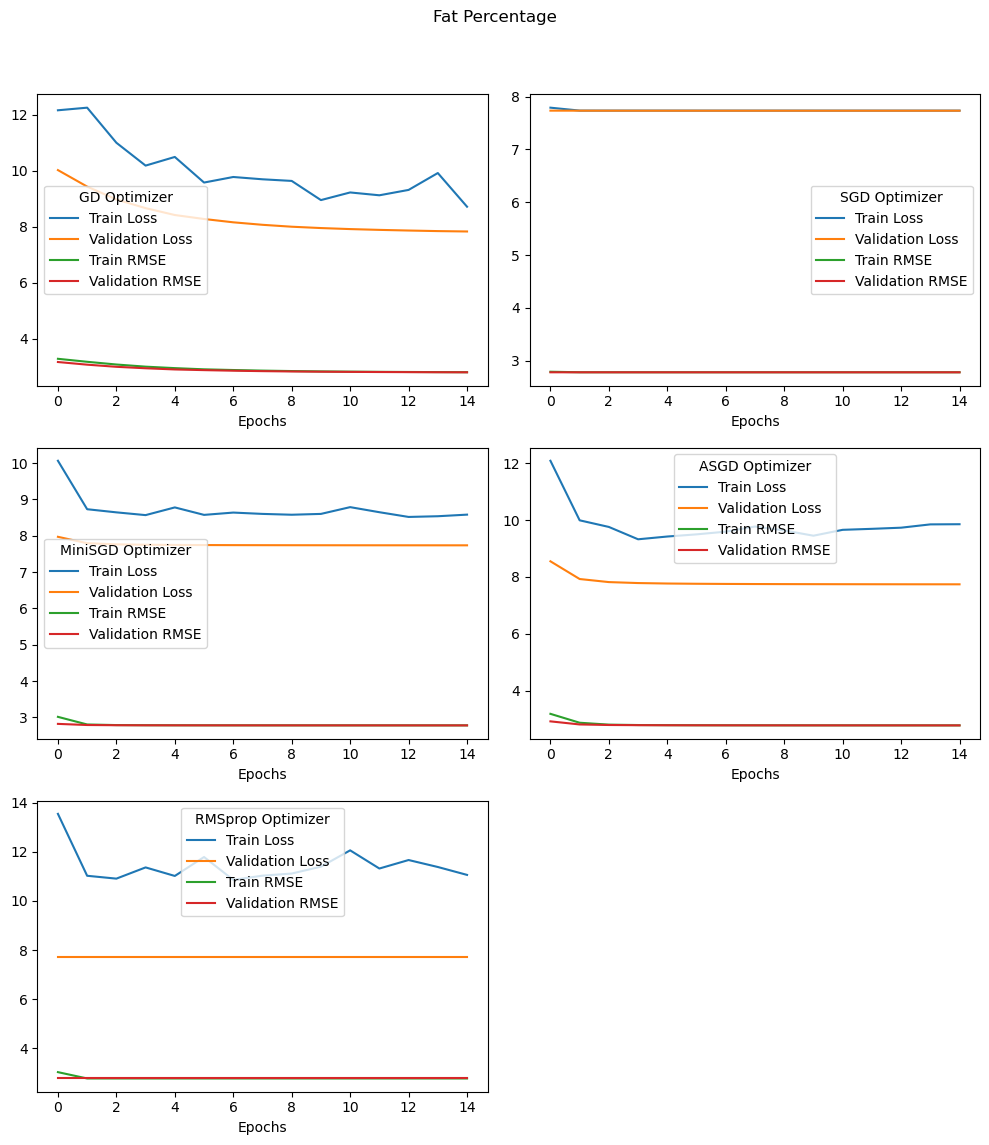

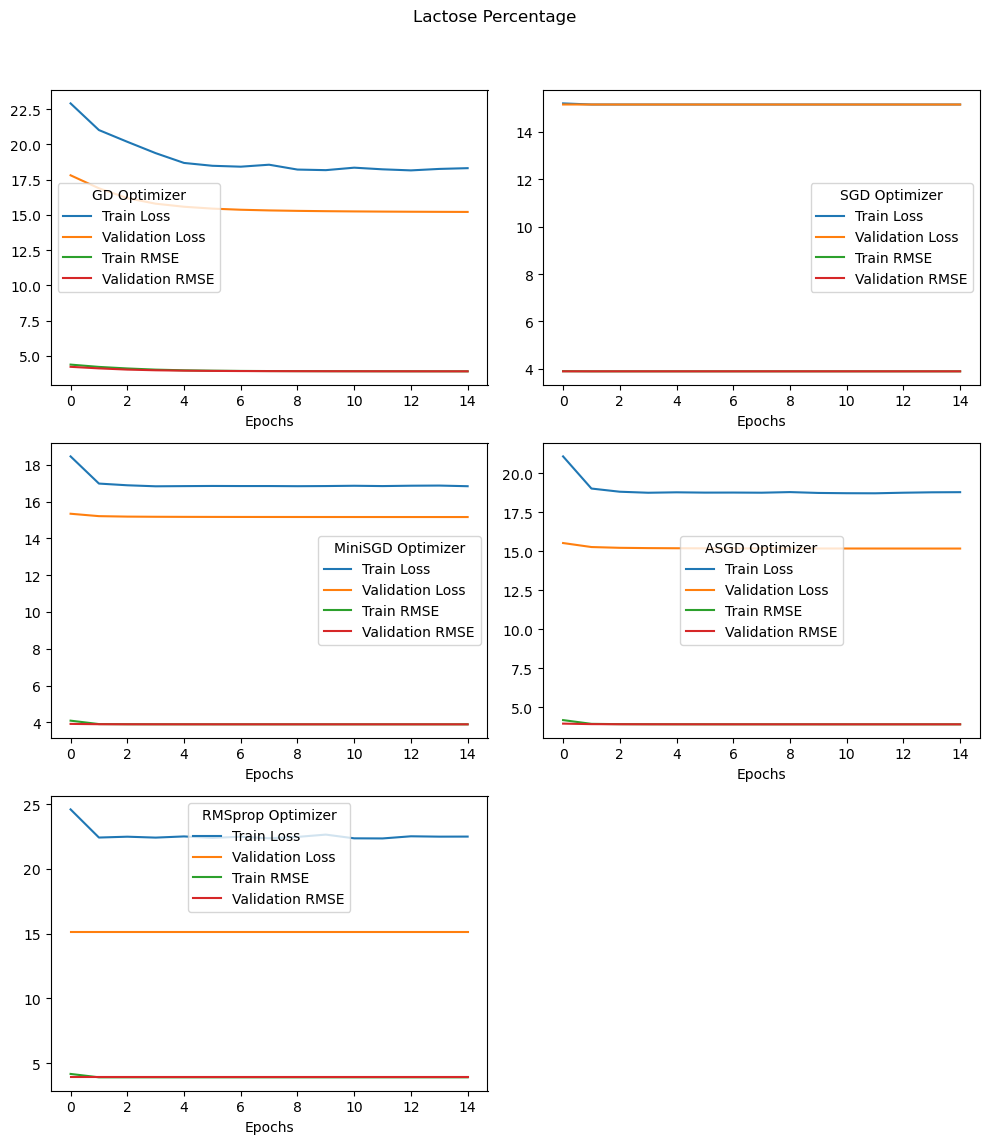

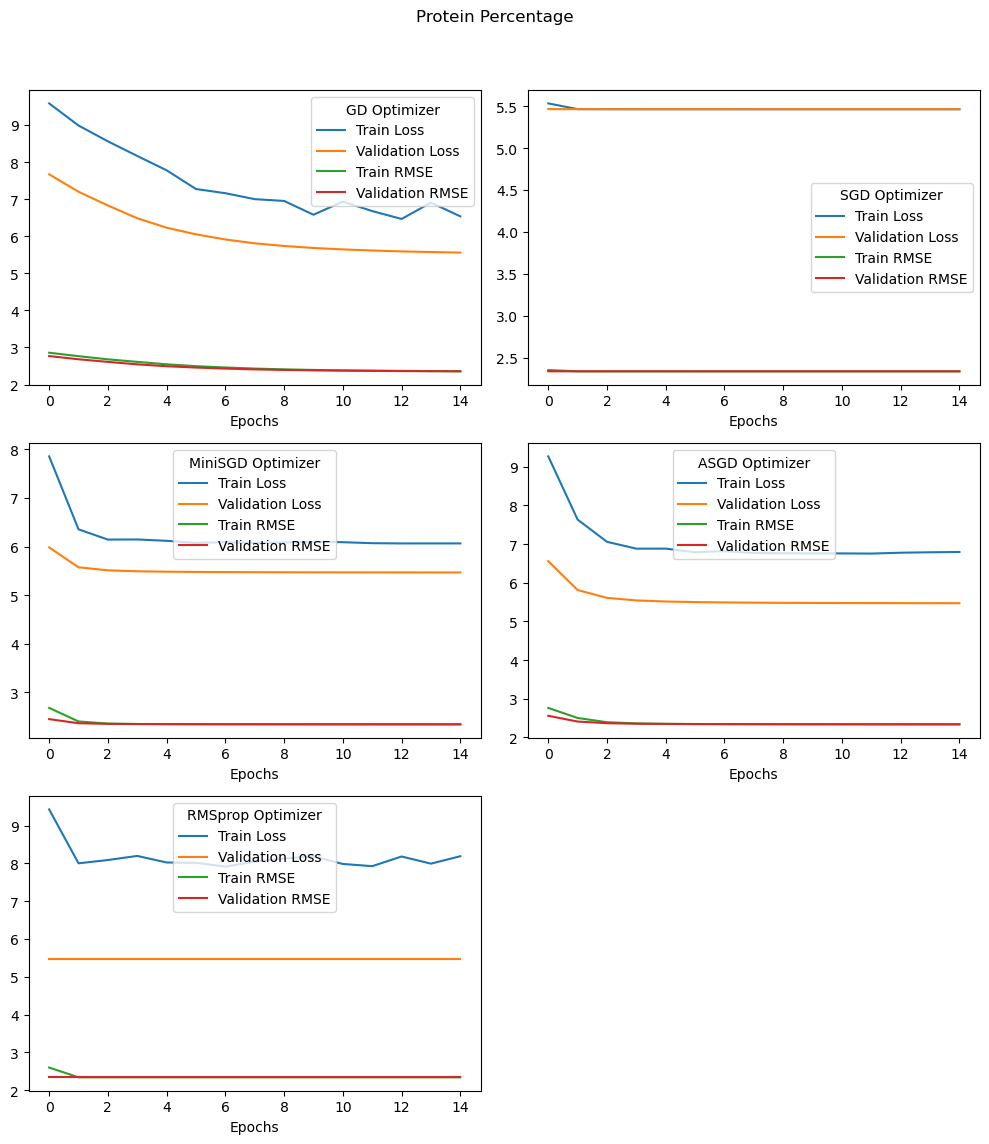

In [26]:
def plot_results(history, title):
    plt.figure(figsize=(10, 12))
    num_plots = len(history.keys())
    rows = 3
    cols = (num_plots + rows - 1) // rows
    
    for i, (nn_name, data) in enumerate(history.items(), 1):
        plt.subplot(rows, cols, i)
        plt.plot(data['metric_0'], label='Train Loss')
        plt.plot(data['metric_1'], label='Validation Loss')
        plt.plot(data['metric_2'], label='Train RMSE')
        plt.plot(data['metric_3'], label='Validation RMSE')
        plt.xlabel('Epochs')
        plt.legend(title=nn_name + ' Optimizer')
    
    plt.suptitle(title)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to fit the suptitle
    plt.show()

# Plot results for each target variable
plot_results(avg_history_fat, "Fat Percentage")
plot_results(avg_history_lactose, "Lactose Percentage")
plot_results(avg_history_protein, "Protein Percentage")


# NEAT

In [27]:
device = 'cpu'
temp_config_path = "temp_config_feedforward_xor.txt"

def fitness_function(genomes, config, inputs, expected_outputs):
    inputs_list = inputs.tolist() if isinstance(inputs, torch.Tensor) else inputs
    outputs_list = expected_outputs.tolist() if isinstance(expected_outputs, torch.Tensor) else expected_outputs
    
    for genome_id, genome in genomes:
        net = neat.nn.FeedForwardNetwork.create(genome, config)
        genome.fitness = 0.0
        for xi, xo in zip(inputs_list, outputs_list):
            output = net.activate(xi)
            genome.fitness -= float((output[0] - xo) ** 2)

class StdOutReporter(neat.reporting.BaseReporter):
    def post_evaluate(self, config, population, species, best_genome):
        fit_mean = np.mean([g.fitness for g in population.values() if g.fitness is not None])
        fit_std = np.std([g.fitness for g in population.values() if g.fitness is not None])

        best_species_id = species.get_species_id(best_genome.key)
        best_fitness = float(best_genome.fitness)
        print('Population\'s average fitness: {0:3.5f} stdev: {1:3.5f}'.format(fit_mean, fit_std))
        print('Best fitness: {0:3.5f} - size: {1!r} - species {2} - id {3}'.format(best_fitness,
                                                                                     best_genome.size(),
                                                                                     best_species_id,
                                                                                     best_genome.key))

def run_neat_for_target(inputs, outputs, config, num_generations=15):
    pop = neat.Population(config)
    pop.add_reporter(neat.StdOutReporter(True))
    pop.add_reporter(StdOutReporter())
    stats = neat.StatisticsReporter()
    pop.add_reporter(stats)

    # Function to calculate fitness for each genome
    def eval_genomes(genomes, config):
        for genome_id, genome in genomes:
            net = neat.nn.FeedForwardNetwork.create(genome, config)
            genome.fitness = 0.0
            for xi, xo in zip(inputs, outputs):
                output = net.activate(xi)
                genome.fitness -= float((output[0] - xo) ** 2)

    # Run NEAT and collect fitness history
    fitness_history = []

    for gen in range(num_generations):
        pop.run(eval_genomes, 1)
        gen_fitnesses = [-genome.fitness for genome in pop.population.values() if genome.fitness is not None]
        gen_rmse = np.sqrt(np.mean(gen_fitnesses))
        fitness_history.append(gen_rmse)

    return fitness_history

# Load configuration file with UTF-8 encoding
config_path = "config-feedforward-xor.txt"
temp_config_path = "temp_config_feedforward_xor.txt"

# Read the configuration file with UTF-8 encoding, and handle errors
with open(config_path, 'r', encoding='utf-8', errors='replace') as f:
    content = f.read()

# Remove problematic characters
cleaned_content = ''.join(c for c in content if ord(c) < 128)

# Write cleaned content to a temporary file with UTF-8 encoding
with open(temp_config_path, 'w', encoding='utf-8') as f:
    f.write(cleaned_content)

# Load configuration using the temporary file
config = neat.config.Config(neat.DefaultGenome, neat.DefaultReproduction,
                            neat.DefaultSpeciesSet, neat.DefaultStagnation,
                            temp_config_path)

# Train NEAT models for each target
num_generations = 15
target_rmse = {
    'lactose': [[] for _ in range(num_generations)],
    'fat': [[] for _ in range(num_generations)],
    'protein': [[] for _ in range(num_generations)]
}

for fold_idx in range(len(X_train_kf)):
    X_train_fold = X_train_kf[fold_idx]
    y_fat_train_fold = y_fat_train_kf[fold_idx]
    y_lactose_train_fold = y_lactose_train_kf[fold_idx]
    y_protein_train_fold = y_protein_train_kf[fold_idx]

    # Convert data to numpy arrays
    X_train_fold_np = X_train_fold.cpu().numpy()
    y_fat_train_fold_np = y_fat_train_fold.cpu().numpy()
    y_lactose_train_fold_np = y_lactose_train_fold.cpu().numpy()
    y_protein_train_fold_np = y_protein_train_fold.cpu().numpy()
    
    # Run NEAT for each target
    lactose_rmse = run_neat_for_target(X_train_fold_np, y_lactose_train_fold_np, config, num_generations)
    fat_rmse = run_neat_for_target(X_train_fold_np, y_fat_train_fold_np, config, num_generations)
    protein_rmse = run_neat_for_target(X_train_fold_np, y_protein_train_fold_np, config, num_generations)
    
    for gen in range(num_generations):
        target_rmse['lactose'][gen].append(lactose_rmse[gen])
        target_rmse['fat'][gen].append(fat_rmse[gen])
        target_rmse['protein'][gen].append(protein_rmse[gen])

# Calculate average RMSE for each epoch across folds
average_rmse = {
    'lactose': [np.mean(rmses) for rmses in target_rmse['lactose']],
    'fat': [np.mean(rmses) for rmses in target_rmse['fat']],
    'protein': [np.mean(rmses) for rmses in target_rmse['protein']]
}


 ****** Running generation 0 ****** 



C:\Users\jaime\AppData\Local\Temp\ipykernel_10488\3362752585.py:42: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  genome.fitness -= float((output[0] - xo) ** 2)


Population's average fitness: -6208.44113 stdev: 0.00000
Best fitness: -6208.44113 - size: (1, 0) - species 1 - id 1
Population's average fitness: -6208.44113 stdev: 0.00000
Best fitness: -6208.44113 - size: (1, 0) - species 1 - id 1
Average adjusted fitness: 0.000
Mean genetic distance 2.249, standard deviation 1.267
Population of 100 members in 3 species:
   ID   age  size   fitness   adj fit  stag
  ====  ===  ====  =========  =======  ====
     1    0    74  -6208.441    0.000     0
     2    0    18  -6208.441    0.000     0
     3    0     8         --       --     0
Total extinctions: 0
Generation time: 0.538 sec

 ****** Running generation 1 ****** 

Population's average fitness: -6167.83255 stdev: 227.66521
Best fitness: -4292.81120 - size: (1, 1) - species 1 - id 152
Population's average fitness: -6167.83255 stdev: 227.66521
Best fitness: -4292.81120 - size: (1, 1) - species 1 - id 152
Average adjusted fitness: 0.026
Mean genetic distance 2.418, standard deviation 1.138
Popul

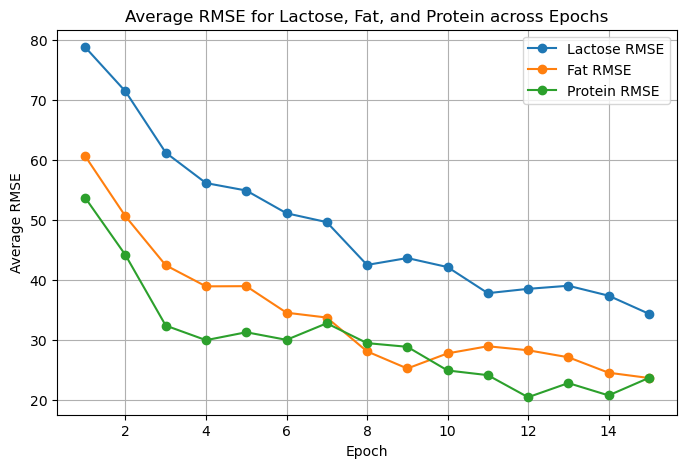

In [28]:
# Plot the RMSE values for each target
epochs = range(1, num_generations + 1)

plt.figure(figsize=(8, 5))
plt.plot(epochs, average_rmse['lactose'], label='Lactose RMSE', marker='o')
plt.plot(epochs, average_rmse['fat'], label='Fat RMSE', marker='o')
plt.plot(epochs, average_rmse['protein'], label='Protein RMSE', marker='o')

plt.xlabel('Epoch')
plt.ylabel('Average RMSE')
plt.title('Average RMSE for Lactose, Fat, and Protein across Epochs')
plt.legend()
plt.grid(True)
plt.show()

# GSGP

In [63]:
# Function to average RMSE values across optimizers
def average_rmse_across_optimizers(history):
    avg_rmse_train = []
    avg_rmse_valid = []
    for nn_name, folds_history in history.items():
        rmse_train_folds = []
        rmse_valid_folds = []
        for fold_name, metrics in folds_history.items():
            _, _, rmse_train, rmse_valid = metrics
            rmse_train_folds.append(rmse_train)
            rmse_valid_folds.append(rmse_valid)
        avg_rmse_train.append(np.mean(rmse_train_folds, axis=0))
        avg_rmse_valid.append(np.mean(rmse_valid_folds, axis=0))
    return np.mean(avg_rmse_train, axis=0), np.mean(avg_rmse_valid, axis=0)

# Average RMSE values across optimizers for each target
avg_rmse_train_fat, avg_rmse_valid_fat = average_rmse_across_optimizers(history_kfold_fat)
avg_rmse_train_lactose, avg_rmse_valid_lactose = average_rmse_across_optimizers(history_kfold_lactose)
avg_rmse_train_protein, avg_rmse_valid_protein = average_rmse_across_optimizers(history_kfold_protein)

# Use NEAT RMSE values (assuming they are precomputed)
neat_rmse_fat = average_rmse['fat']
neat_rmse_lactose = average_rmse['lactose']
neat_rmse_protein = average_rmse['protein']

# Store RMSE values for GSGP model
gsgp_rmse_valid = []

seed = 1
# device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = 'mps' if torch.backends.mps.is_available() else 'cpu'
shuffle, p_test, p_val, n_batches_pct = True, .3, .3, 1

# Setup logging properties
file_dir = './log/'
file_name = 'intro_gsgp.log'
log_path = file_dir + file_name
path_rts = os.path.join(file_dir, 'reconstruct', 'rts')
path_init_pop = os.path.join(file_dir, 'reconstruct', 'init_pop')

if os.path.exists(file_dir + file_name):
    os.remove(file_dir + file_name)
if not os.path.exists(file_dir):
    os.makedirs(file_dir)

for path_i in [file_dir, path_init_pop, path_rts]:
    if not os.path.exists(path_i):
        os.makedirs(path_i)

print([log_path, path_rts, path_init_pop])

['./log/intro_gsgp.log', './log/reconstruct\\rts', './log/reconstruct\\init_pop']


In [73]:
# Store RMSE values for GSGP model
gsgp_rmse_valid = []

# Loop over each target variable
for target_index in range(len(X_train_kf)):
    # Initialize an empty list to store RMSE values for each epoch
    target_rmse_values = []
    
    # Code to train GSGP model for each target variable
    batch_size = len(X_train_kf[target_index])
    ds_train_kf = TensorDataset(X_train_kf[target_index], y_lactose_train_kf[target_index])
    ds_val_kf = TensorDataset(X_val_kf[target_index], y_lactose_val_kf[target_index])
    dl_train_1  = DataLoader(ds_train_kf, batch_size, shuffle)
    dl_val_1 = DataLoader(ds_val_kf, batch_size, shuffle)
    
    fset = [function_map['add'], function_map['sub'], function_map['mul'], function_map['div']]
    sspace_sml_gs = {
        'n_dims': X_train_kf[target_index].shape[1],
        'function_set': fset, 'constant_set': ERC(-1., 1.),
        'p_constants': 0.1,
        'max_init_depth': 3,
        'device': device,
        'n_batches': 1
    }
    pi_sml = SML(
        sspace=sspace_sml_gs,
        ffunction=Ffunctions('rmse'),
        dl_train=dl_train_1, dl_test=dl_val_1
    )
    ps = batch_size
    selection_pressure = .07
    mutation_prob = .1
    xo_prob = .9
    seed = 1
    has_elitism = True
    allow_reproduction = False
    to, by = 5.0, 0.25
    ms = torch.arange(by, to + by, by, device=device)

    mheuristic = GeneticAlgorithm(
        pi=pi_sml,
        initializer=grow,
        selector=prm_tournament(pressure=selection_pressure),
        pop_size=ps,
        p_m=mutation_prob,
        p_c=xo_prob,
        elitism=has_elitism,
        reproduction=allow_reproduction,  # False = or xo or mutation
        device=device,
        seed=seed,
        crossover=prm_gs_xo(prm_grow(sspace=pi_sml.sspace), device=device),
        mutator=prm_gs_mtn(prm_grow(sspace=pi_sml.sspace), ms)
    )
    mheuristic._initialize()

    num_epochs = 15
    # Train the GSGP model for each epoch
    for epoch in range(num_epochs):  # Assuming num_epochs is defined elsewhere
        # Train the GSGP model for one epoch
        
        # Calculate RMSE for the current epoch and store it
        rmse_valid = mheuristic.best_sol.fit
        target_rmse_values.append(rmse_valid)
    
    # Store the RMSE values for the current target variable
    gsgp_rmse_valid.append(target_rmse_values)
    
    # Print relevant information
    print("Target Index:", target_index)
    print("Best Solution:", mheuristic.best_sol)
    print('------------------------')

# Now gsgp_rmse_valid should contain 15 RMSE values for each target variable

Target Index: 0
Best Solution: <gpolnel.utils.solution.Solution object at 0x0000021B5F44EE50>
------------------------
Target Index: 1
Best Solution: <gpolnel.utils.solution.Solution object at 0x0000021B5F5D6E10>
------------------------
Target Index: 2
Best Solution: <gpolnel.utils.solution.Solution object at 0x0000021B66DC0510>
------------------------
Target Index: 3
Best Solution: <gpolnel.utils.solution.Solution object at 0x0000021B5F476C50>
------------------------
Target Index: 4
Best Solution: <gpolnel.utils.solution.Solution object at 0x0000021B5F59C550>
------------------------


# Wilcoxon Signed-Rank Test

In [31]:
# Function to average RMSE values across optimizers
def average_rmse_across_optimizers(history):
    avg_rmse_train = []
    avg_rmse_valid = []
    for nn_name, folds_history in history.items():
        rmse_train_folds = []
        rmse_valid_folds = []
        for fold_name, metrics in folds_history.items():
            _, _, rmse_train, rmse_valid = metrics
            rmse_train_folds.append(rmse_train)
            rmse_valid_folds.append(rmse_valid)
        avg_rmse_train.append(np.mean(rmse_train_folds, axis=0))
        avg_rmse_valid.append(np.mean(rmse_valid_folds, axis=0))
    return np.mean(avg_rmse_train, axis=0), np.mean(avg_rmse_valid, axis=0)

# Average RMSE values across optimizers for each target
avg_rmse_train_fat, avg_rmse_valid_fat = average_rmse_across_optimizers(history_kfold_fat)
avg_rmse_train_lactose, avg_rmse_valid_lactose = average_rmse_across_optimizers(history_kfold_lactose)
avg_rmse_train_protein, avg_rmse_valid_protein = average_rmse_across_optimizers(history_kfold_protein)

# Use NEAT RMSE values (assuming they are precomputed)
neat_rmse_fat = average_rmse['fat']
neat_rmse_lactose = average_rmse['lactose']
neat_rmse_protein = average_rmse['protein']

# Perform Wilcoxon Signed-Rank Test
def perform_wilcoxon_test(avg_rmse_nn, neat_rmse, target_variable):
    # Ensure both lists have the same length for a valid test
    min_length = min(len(avg_rmse_nn), len(neat_rmse))
    avg_rmse_nn = avg_rmse_nn[:min_length]
    neat_rmse = neat_rmse[:min_length]
    
    stat, p_value = wilcoxon(avg_rmse_nn, neat_rmse)
    print(f"Wilcoxon test for {target_variable} RMSE: statistic={stat}, p-value={p_value}")

# Perform tests for each target variable
perform_wilcoxon_test(avg_rmse_valid_fat, neat_rmse_fat, "fat")
perform_wilcoxon_test(avg_rmse_valid_lactose, neat_rmse_lactose, "lactose")
perform_wilcoxon_test(avg_rmse_valid_protein, neat_rmse_protein, "protein")

Wilcoxon test for fat RMSE: statistic=0.0, p-value=6.103515625e-05
Wilcoxon test for lactose RMSE: statistic=0.0, p-value=6.103515625e-05
Wilcoxon test for protein RMSE: statistic=0.0, p-value=6.103515625e-05


# Friedman Test

In [74]:
# Print lengths of RMSE lists for each model
print("Length of avg_rmse_valid_fat:", len(avg_rmse_valid_fat))
print("Length of neat_rmse_fat:", len(neat_rmse_fat))
print("Length of gsgp_rmse_valid:", len(gsgp_rmse_valid))
print("---")
print("Length of avg_rmse_valid_lactose:", len(avg_rmse_valid_lactose))
print("Length of neat_rmse_lactose:", len(neat_rmse_lactose))
print("Length of gsgp_rmse_valid:", len(gsgp_rmse_valid))
print("---")
print("Length of avg_rmse_valid_protein:", len(avg_rmse_valid_protein))
print("Length of neat_rmse_protein:", len(neat_rmse_protein))
print("Length of gsgp_rmse_valid:", len(gsgp_rmse_valid))

Length of avg_rmse_valid_fat: 15
Length of neat_rmse_fat: 15
Length of gsgp_rmse_valid: 5
---
Length of avg_rmse_valid_lactose: 15
Length of neat_rmse_lactose: 15
Length of gsgp_rmse_valid: 5
---
Length of avg_rmse_valid_protein: 15
Length of neat_rmse_protein: 15
Length of gsgp_rmse_valid: 5


In [61]:
# Function to perform Friedman test for each target variable
def perform_friedman_test(avg_rmse_nn, neat_rmse, gsgp_rmse, target_variable):
    # Ensure all lists have the same length for a valid test
    min_length = min(len(avg_rmse_nn), len(neat_rmse), len(gsgp_rmse))
    avg_rmse_nn = avg_rmse_nn[:min_length]
    neat_rmse = neat_rmse[:min_length]
    gsgp_rmse = gsgp_rmse[:min_length]
    
    # Perform the Friedman test
    stat, p_value = friedmanchisquare(avg_rmse_nn, neat_rmse, gsgp_rmse)
    
    # Print the results
    print(f"Friedman test for {target_variable} RMSE: statistic={stat}, p-value={p_value}")

# Perform tests for each target variable
perform_friedman_test(avg_rmse_valid_fat, neat_rmse_fat, gsgp_rmse_valid, "fat")
perform_friedman_test(avg_rmse_valid_lactose, neat_rmse_lactose, gsgp_rmse_valid, "lactose")
perform_friedman_test(avg_rmse_valid_protein, neat_rmse_protein, gsgp_rmse_valid, "protein")

ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 5 and the array at index 2 has size 15